In [1]:
import re
import pandas as pd
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import networkx as nx
from PIL import Image

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [2]:
data_path = Path('../data/')
search_res_html = (data_path / 'nidb_nimh_search_2018_11_07.htm').read_text()

In [3]:
ipid_pat = re.compile(r'\?ipid=([0-9]*)')

In [4]:
ipids = pd.unique(re.findall(ipid_pat,search_res_html))

In [5]:
def get_pj_info(ipid):
    url_root = "https://intramural.nih.gov/search/"
    url = f'{url_root}searchview.taf?ipid={ipid}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    headings = [dd.text for dd in soup.findAll('div', attrs={'class':'headings'})]
    data = []
    for dd in soup.findAll('div', attrs={'class':'data'}):
        if "Show all" in dd.text:
            data.append(get_hidden_data(url_root, dd))
        else:
            data.append(dd.text)
            
    # Get project number
    headings.append('pj_num')
    data.append(soup.findAll('div', attrs={'class':'contentlabel'})[0].text)

    # Get project bibliography
    
    bib_head = [dd for dd in soup.findAll('div', attrs={'class':'headings'}) if "See Project Bibliography" in dd.text]
    if len(bib_head) > 0:
        assert len(bib_head) == 1
        headings.append('Project Bibliography')
        data.append(get_hidden_data(url_root, bib_head[0], bib=True))
    return (ipid, headings, data)

def get_hidden_data(url_root, dd, bib = False):
    aref = dd.findAll(name='a')[0]
    show_all_search = [aa for aa in aref.attrs['onclick'].split(',') if 'searchview' in aa][0].strip("'")
    show_all_url = f'{url_root}{show_all_search}'
    show_all_page = requests.get(show_all_url)

    sa_soup = BeautifulSoup(show_all_page.text, 'html.parser')
    if bib:
        sa_datas = sa_soup.findAll('div', attrs={'style':'margin: -1.6em 0px 5px 2em;'})
        sa_data = [dd.text for dd in sa_datas]
        return sa_data
    else:
        sa_datas = sa_soup.findAll('div', attrs={'class':'data'})
        assert len(sa_datas) == 1
        sa_data = sa_datas[0].text.split('\n')
        sa_data = [sd for sd in sa_data if sd != '']
        return sa_data

In [6]:
def split_drop(x,split_on='\n'):
    if not isinstance(x,list) and pd.notnull(x):
        return [sd for sd in x.split('\n') if sd != '']
    else:
        return x

In [7]:
pj_info = [get_pj_info(ipid) for ipid in ipids]

In [8]:
pj_clean = []
for ipid, headings, data in pj_info:
    # clean up headings
    for hi,head in enumerate(headings):
        #Pubs generated
        if 'Lab Staff and Collaborators' in head:
            headings[hi] = 'Lab Staff and Collaborators'
        if 'Extramural Collaborator' in head:
            headings[hi] = 'Extramural Collaborators'
        if 'Publications Generated' in head:
            if 'See Project Bibliography' in head:
                more_refs = True
            headings[hi] = 'Publications Generated'
        else:
            headings[hi] = headings[hi].strip()
    res = pd.DataFrame.from_dict([{h:d for h,d in zip(headings,data)}])
    res['ipid'] = ipid
    res['more_references'] = more_refs
    pj_clean.append(res)

In [9]:
pj_df = pd.concat(pj_clean, sort=False).reset_index(drop=True)

In [10]:
col_rn = {'Collaborators from other NIH organizations': 'NIH_collab',
          'Collaborators from other NIMH organizations': 'NIMH_collab',
          'Extramural Collaborators': 'EM_collab'}
pj_df = pj_df.rename(columns=col_rn)

In [11]:
pj_df.EM_collab = pj_df.EM_collab.apply(split_drop)
pj_df.NIH_collab = pj_df.NIH_collab.apply(split_drop)
pj_df.NIMH_collab = pj_df.NIMH_collab.apply(split_drop)

In [12]:
pj_df['Research Organization'] = pj_df['Research Organization'].str.strip()

In [13]:
pj_df['PI'] = pj_df['Principal Investigator'].str.strip().str.split('\n').str[0]
pj_df['PI'] = pj_df['PI'].fillna(pj_df['Lead Investigator'].str.strip())

In [14]:
fund_df = pd.read_csv('../data/SR_13Nov2018_120853_MR_167922.csv', skiprows=4)
fund_df['short_pj_num'] = fund_df['Project Number'].str.split('MH').str[-1].str.split('-').str[0]
pj_df['short_pj_num'] = pj_df.pj_num.str.split('-').str[0].str.strip('MH')
pj_df = pj_df.merge(fund_df.loc[(fund_df.FY == 2017) & (fund_df['Funding IC'] == 'NIMH'), 
                        ['short_pj_num', 'FY Total Cost by IC']],
            how='left',
            on='short_pj_num')

In [15]:
import nltk

In [16]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [17]:
stopwords.extend(["'s",
                  "et",
                  "et al",
                  "et al.",
                  "al",
                  "al.",
                  "and/or",
                  "e.g.",
                  "i.e.",
                  "dr."])

In [18]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [19]:
pj_df['pj_text'] = pj_df['Goals and Objectives'] + pj_df['Summary']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [21]:
tfidf_matrix = tfidf_vectorizer.fit_transform(pj_df['pj_text'].values)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dr', 'dure', 'e.g', 'i.e', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


In [22]:
tfidf_matrix.shape

(91, 814)

In [23]:
terms = tfidf_vectorizer.get_feature_names()

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
tfidf_matrix

<91x814 sparse matrix of type '<class 'numpy.float64'>'
	with 17807 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.cluster import KMeans, ward_tree
from sklearn.metrics import silhouette_samples, silhouette_score

num_clusters = 4

km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 639 ms, sys: 7.71 ms, total: 647 ms
Wall time: 659 ms


CPU times: user 878 ms, sys: 28.3 ms, total: 906 ms
Wall time: 375 ms


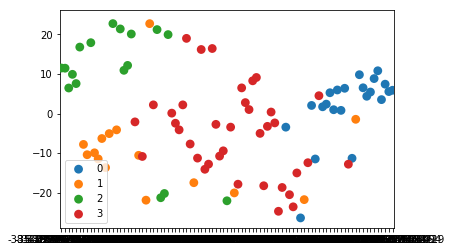

In [27]:
from sklearn.manifold import TSNE
mds = TSNE(perplexity=5, init='pca', learning_rate=10, metric='cosine')
%time pj_mds = mds.fit_transform(tfidf_matrix.toarray())
sns.pointplot(pj_mds[:,0], pj_mds[:,1], hue=clusters, join=False)

In [28]:
 pj_df['label'] =  pj_df['PI'].str.split(';').str[0] + ', '  + pj_df['Research Organization'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '')
 pj_df['longlabel'] = pj_df['PI'].str.split(';').str[0] + ', '  + pj_df['Research Organization'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '') + ', ' +  pj_df['Report Title'].str.strip()

## Hierarchical clusters

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

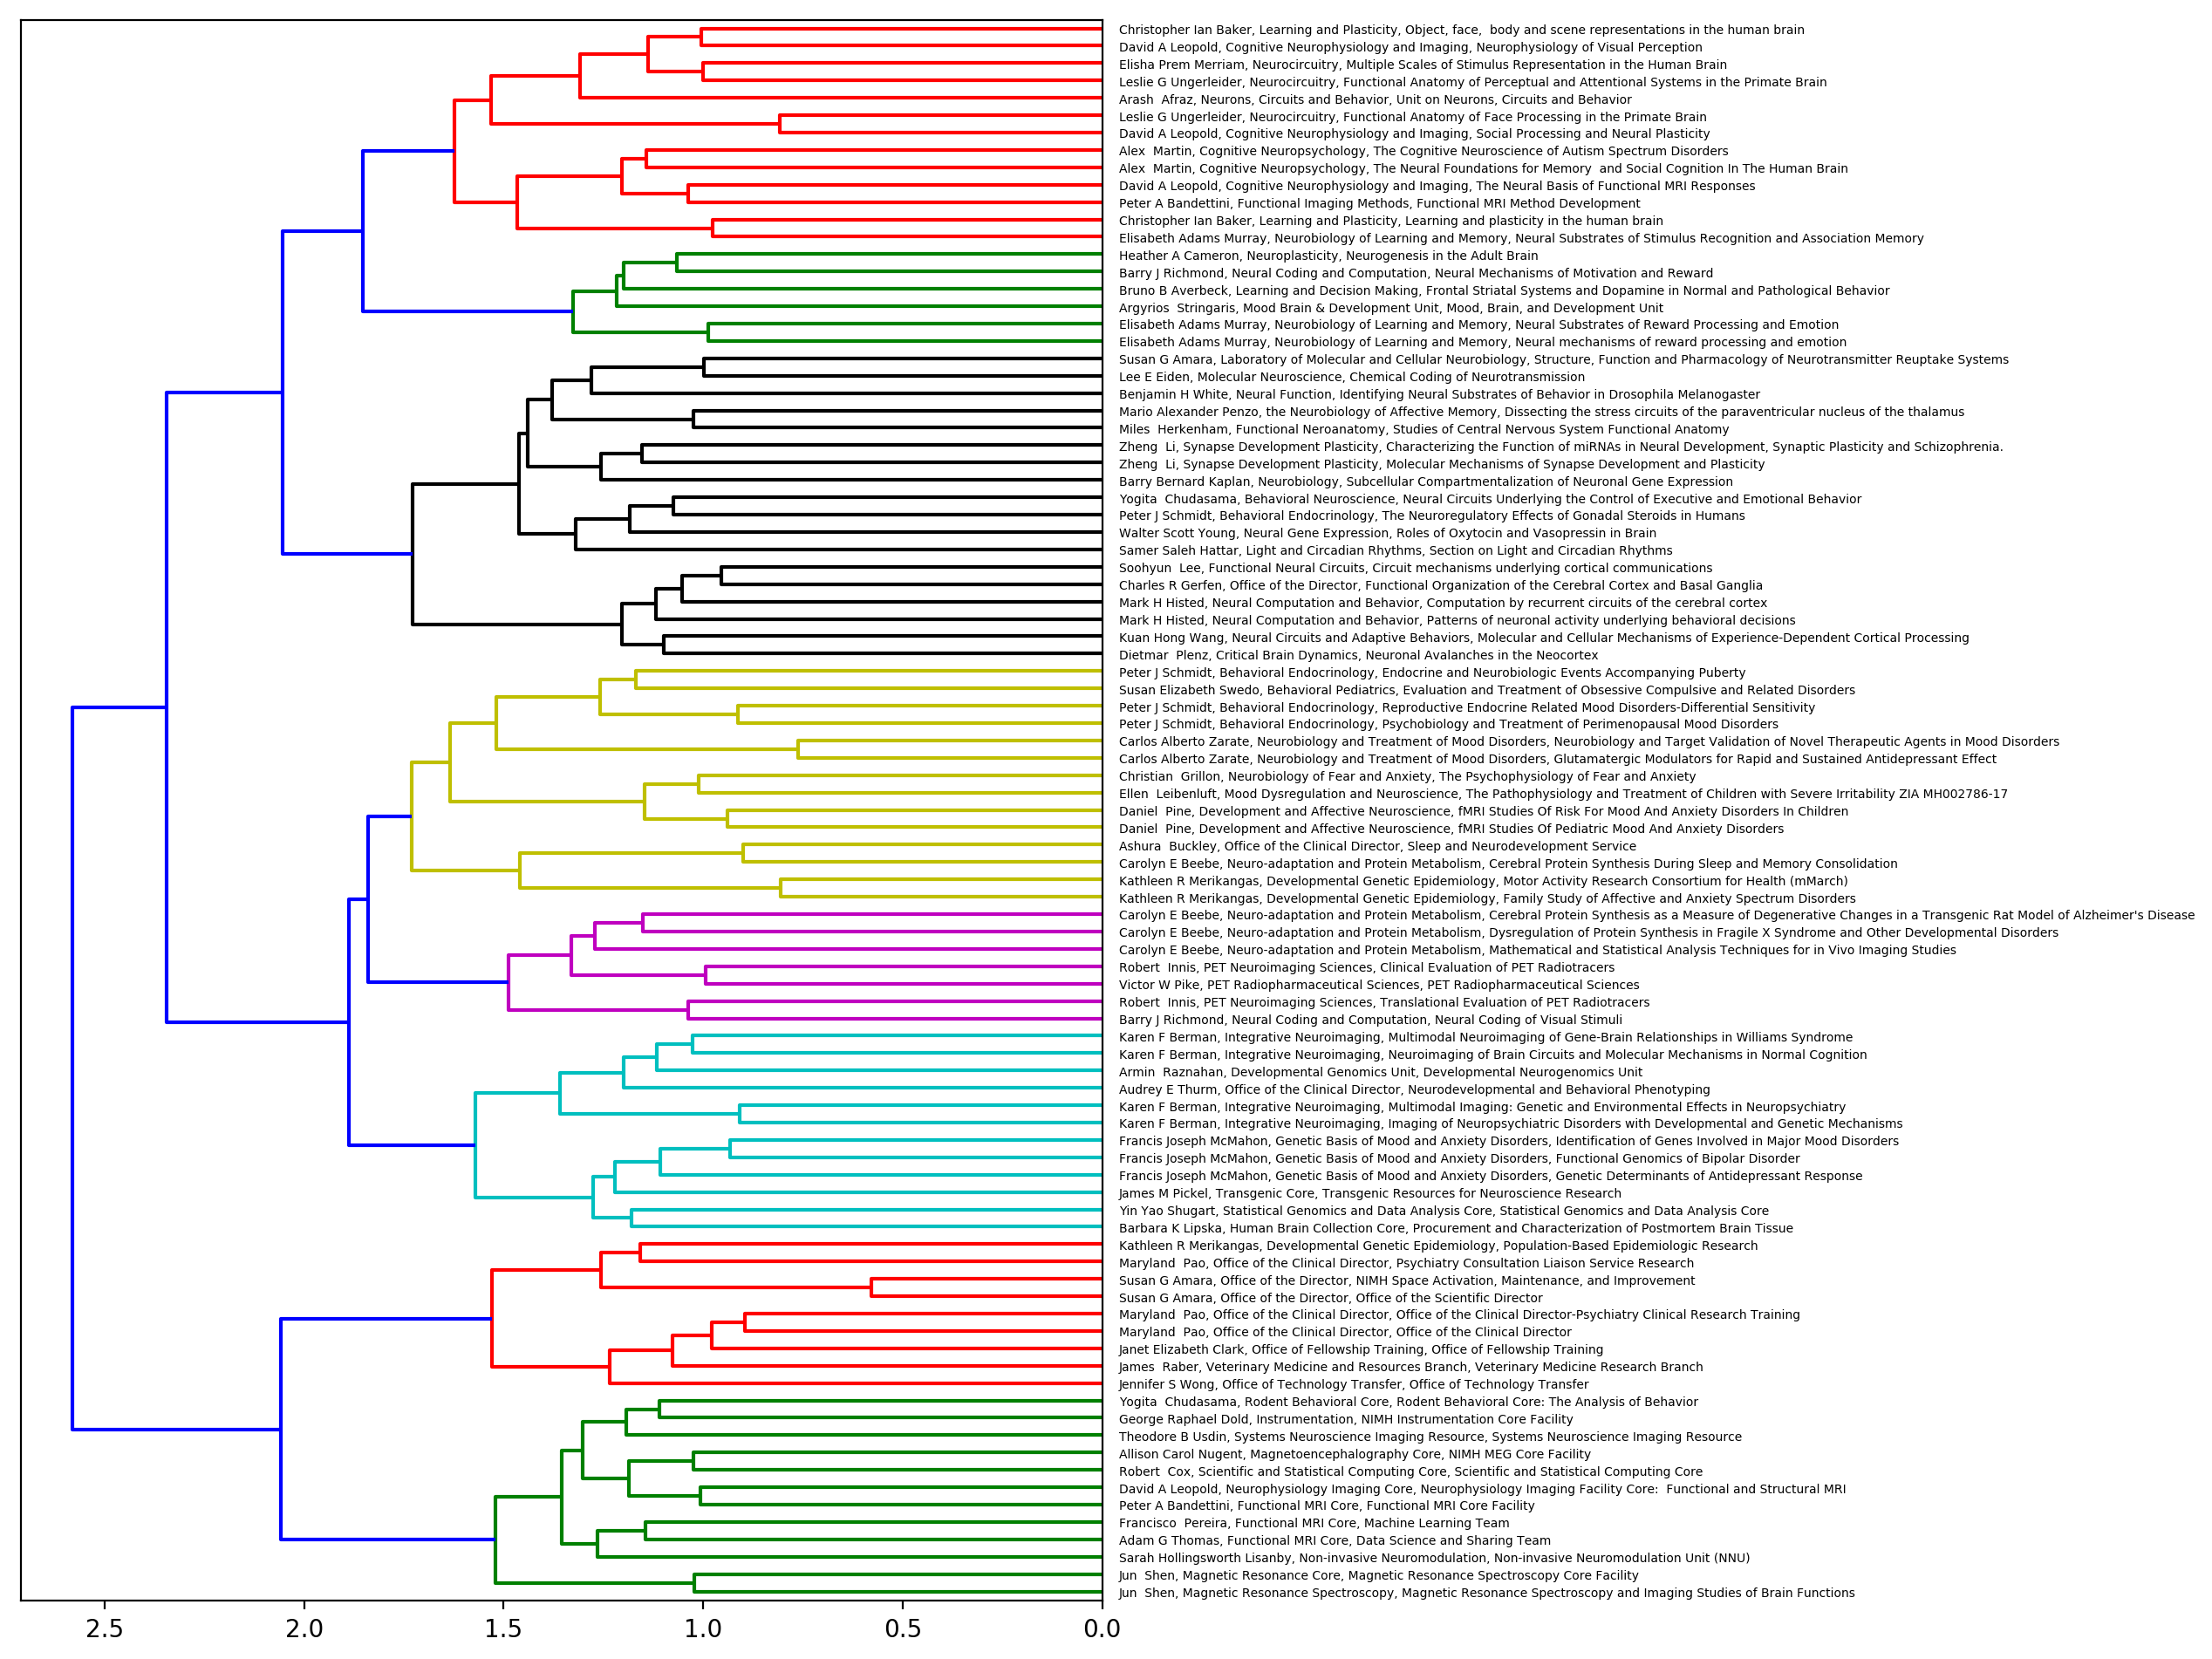

In [30]:
import scipy.cluster.hierarchy as shc
Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(8,12), dpi=200)
dend = shc.dendrogram(Z, labels=pj_df['longlabel'].values, orientation='left', color_threshold=1.8)

In [31]:
pj_df.to_csv('../data/project_df.csv')

In [32]:
len(dend['ivl'])

91

In [33]:
clusters = shc.fcluster(Z, 1.8, criterion='distance')-1

In [34]:
pj_df['cluster'] = clusters

In [35]:
cluster_centers = []
for cl in np.unique(clusters):
    ind = clusters == cl 
    cluster_centers.append(np.median(tfidf_matrix.toarray()[ind,:],0))
cluster_centers = np.array(cluster_centers)

In [36]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = cluster_centers.argsort()[:, ::-1] 

cluster_budgets = pj_df.groupby('cluster')[['FY Total Cost by IC']].sum().values

for i in np.unique(clusters):
    cb = int(cluster_budgets[i][0])
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print(f"Cluster {i:d} total 2017 budget: ${cb:,d}")
    print() #add whitespace
    
    print("Cluster %d Section:" % i, end='')
    for title in pj_df.loc[pj_df['cluster']==i, 'label'].tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print()
print()


Top terms per cluster:

Cluster 0 words: imag, data, research, core, nih, project, softwar, mri, support, method,
Cluster 0 total 2017 budget: $18,635,734

Cluster 0 Section: Jun  Shen, Magnetic Resonance Spectroscopy,
 Sarah Hollingsworth Lisanby, Non-invasive Neuromodulation,
 Peter A Bandettini, Functional MRI Core,
 Robert  Cox, Scientific and Statistical Computing Core,
 Allison Carol Nugent, Magnetoencephalography Core,
 Jun  Shen, Magnetic Resonance Core,
 David A Leopold, Neurophysiology Imaging Core,
 George Raphael Dold, Instrumentation,
 Yogita  Chudasama, Rodent Behavioral Core,
 Adam G Thomas, Functional MRI Core,
 Theodore B Usdin, Systems Neuroscience Imaging Resource,
 Francisco  Pereira, Functional MRI Core,


Cluster 1 words: nimh, research, clinic, nih, irp, program, provid, offic, nation, scientif,
Cluster 1 total 2017 budget: $27,563,168

Cluster 1 Section: Susan G Amara, Office of the Director,
 Maryland  Pao, Office of the Clinical Director,
 Kathleen R Merikanga

# cluster at research organization level

In [37]:
pj_df.loc[:,['PI', 'Research Organization', 'Report Title']]

PI  \
0             Carolyn E Beebe; PhD   
1            Miles  Herkenham; PhD   
2             Barry J Richmond; MD   
3        Leslie G Ungerleider; PhD   
4                 Lee E Eiden; PhD   
5            Charles R Gerfen; PhD   
6      Walter Scott Young; MD, PhD   
7              Peter J Schmidt; MD   
8                Alex  Martin; PhD   
9             Barry J Richmond; MD   
10              Karen F Berman; MD   
11       Susan Elizabeth Swedo; MD   
12              Karen F Berman; MD   
13     Elisabeth Adams Murray; PhD   
14       Barry Bernard Kaplan; PhD   
15                Daniel  Pine; MD   
16                Daniel  Pine; MD   
17     Peter A Bandettini; BS, PhD   
18          Heather A Cameron; PhD   
19           Ellen  Leibenluft; MD   
20              Victor W Pike; PhD   
21               Robert  Innis; MD   
22             Dietmar  Plenz; PhD   
23         Christian  Grillon; PhD   
24           Benjamin H White; PhD   
25                  Jun  Shen; PhD   
26      Kathleen R Merikangas; PhD   
27      Francis Joseph McMahon; MD   
28            David A Leopold; PhD   
29      Francis Joseph McMahon; MD   
30      Francis Joseph McMahon; MD   
31               Robert  Innis; MD   
32       Carlos Alberto Zarate; MD   
33              Karen F Berman; MD   
34             Peter J Schmidt; MD   
35             Peter J Schmidt; MD   
36                  Zheng  Li; PhD   
37                  Zheng  Li; PhD   
38     Elisabeth Adams Murray; PhD   
39     Elisabeth Adams Murray; PhD   
40      Christopher Ian Baker; PhD   
41            David A Leopold; PhD   
42             Kuan Hong Wang; PhD   
43            David A Leopold; PhD   
44      Christopher Ian Baker; PhD   
45              Susan G Amara; PhD   
46       Leslie G Ungerleider; PhD   
47               Alex  Martin; PhD   
48               Maryland  Pao; MD   
49       Carlos Alberto Zarate; MD   
50                Bruno B Averbeck   
51             Peter J Schmidt; MD   
52            Carolyn E Beebe; PhD   
53            Carolyn E Beebe; PhD   
54              Karen F Berman; MD   
55              Susan G Amara; PhD   
56            Carolyn E Beebe; PhD   
57                 Armin  Raznahan   
58           Mario Alexander Penzo   
59          Yogita  Chudasama; PhD   
60      Kathleen R Merikangas; PhD   
61      Kathleen R Merikangas; PhD   
62     Sarah Hollingsworth Lisanby   
63              Mark H Histed; PhD   
64            Argyrios  Stringaris   
65           Arash  Afraz; MD, PhD   
66               Soohyun  Lee; PhD   
67              Samer Saleh Hattar   
68             Elisha Prem Merriam   
69              Mark H Histed; PhD   
70     Peter A Bandettini; BS, PhD   
71                Robert  Cox; PhD   
72       Allison Carol Nugent; PhD   
73                  Jun  Shen; PhD   
74            David A Leopold; PhD   
75         James M Pickel; AB, PhD   
76           Barbara K Lipska; PhD   
77  George Raphael Dold; MME, BSEE   
78          Yogita  Chudasama; PhD   
79              Adam G Thomas; PhD   
80             Audrey E Thurm; PhD   
81                 Ashura  Buckley   
82       Theodore B Usdin; MD, PhD   
83            Yin Yao Shugart; PhD   
84              Francisco  Pereira   
85               Maryland  Pao; MD   
86               Maryland  Pao; MD   
87          James  Raber; DVM, PhD   
88              Susan G Amara; PhD   
89           Janet Elizabeth Clark   
90                 Jennifer S Wong   

                                               Research Organization  \
0           Section on Neuro-adaptation and Protein Metabolism, NIMH   
1                            Section on Functional Neroanatomy, NIMH   
2                     Section on Neural Coding and Computation, NIMH   
3                                    Section on Neurocircuitry, NIMH   
4                            Section on Molecular Neuroscience, NIMH   
5                                       Office of the Director, NIMH   
6                            Se

In [38]:
pj_df['Report Title'] = pj_df['Report Title'].str.strip()

In [39]:
manual_edits = [('Charles R Gerfen; PhD', 'Office of the Director, NIMH', 'Functional Organization of the Cerebral Cortex and Basal Ganglia', 'Organization of the Cortex and Basal Ganglia'),
                ('Susan G Amara; PhD', 'Office of the Director, NIMH', 'Office of the Scientific Director', 'Office of the Scientific Director'),
                ('Maryland Pao; MD', 'Office of the Clinical Director, NIMH', 'Psychiatry Consultation Liaison Service Research', 'Psychiatry Consultation Liaison Service Research'),
                ('Adam G Thomas; PhD', 'Functional MRI Core, NIMH', 'Data Science and Sharing Team', 'Data Science and Sharing Team'),
                ('Audrey E Thurm; PhD', 'Office of the Clinical Director, NIMH', 'Neurodevelopmental and Behavioral Phenotyping', 'Neurodevelopmental and Behavioral Phenotyping'),
                ('Ashura  Buckley', 'Office of the Clinical Director, NIMH', 'Sleep and Neurodevelopment Service', 'Sleep and Neurodevelopment Service'),
                ('Francisco  Pereira', 'Functional MRI Core, NIMH', 'Machine Learning Team', 'Machine Learning Team'),
                ('Maryland Pao; MD', 'Office of the Clinical Director, NIMH', 'Office of the Clinical Director-Psychiatry Clinical Research Training', 'Psychiatry Clinical Research Training'),
                ('Susan G Amara; PhD', 'Office of the Director, NIMH', 'NIMH Space Activation, Maintenance, and Improvement', 'Space Activation, Maintenance, and Improvement'),
               ]

In [40]:
pj_df.loc[(pj_df['Research Organization']=='Office of the Clinical Director, NIMH'), ['PI', 'Research Organization', 'Report Title']].iloc[2,:]

PI                                             Ashura  Buckley
Research Organization    Office of the Clinical Director, NIMH
Report Title                Sleep and Neurodevelopment Service
Name: 81, dtype: object

In [41]:
pj_df['ro'] = pj_df['Research Organization']
for me in manual_edits:
    pj_df.loc[(pj_df['PI']==me[0]) & (pj_df['Research Organization']==me[1]) & (pj_df['Report Title']==me[2]), 'ro'] = me[3]

In [42]:
pi_df = pj_df.groupby(['PI', 'ro'],as_index=False)[['pj_text']].sum()
pi_df['label'] =  pi_df['PI'].str.split(';').str[0].str.split(' ').str[-1] + ', '  + pi_df['ro'].str.replace(', NIMH', '').str.replace('Unit on ', '').str.replace('Section on the ', '').str.replace('Section on ', '').str.replace('Laboratory of ', '')


In [43]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(pi_df['pj_text'].values)


/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dr', 'dure', 'e.g', 'i.e', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


In [44]:
pi_df['helped'] = np.array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [45]:
pi_df

PI  \
0               Adam G Thomas; PhD   
1                Alex  Martin; PhD   
2        Allison Carol Nugent; PhD   
3            Arash  Afraz; MD, PhD   
4             Argyrios  Stringaris   
5                  Armin  Raznahan   
6                  Ashura  Buckley   
7              Audrey E Thurm; PhD   
8            Barbara K Lipska; PhD   
9        Barry Bernard Kaplan; PhD   
10            Barry J Richmond; MD   
11           Benjamin H White; PhD   
12                Bruno B Averbeck   
13       Carlos Alberto Zarate; MD   
14            Carolyn E Beebe; PhD   
15           Charles R Gerfen; PhD   
16         Christian  Grillon; PhD   
17      Christopher Ian Baker; PhD   
18                Daniel  Pine; MD   
19            David A Leopold; PhD   
20            David A Leopold; PhD   
21             Dietmar  Plenz; PhD   
22     Elisabeth Adams Murray; PhD   
23             Elisha Prem Merriam   
24           Ellen  Leibenluft; MD   
25      Francis Joseph McMahon; MD   
26              Francisco  Pereira   
27  George Raphael Dold; MME, BSEE   
28          Heather A Cameron; PhD   
29          James  Raber; DVM, PhD   
30         James M Pickel; AB, PhD   
31           Janet Elizabeth Clark   
32                 Jennifer S Wong   
33                  Jun  Shen; PhD   
34                  Jun  Shen; PhD   
35              Karen F Berman; MD   
36      Kathleen R Merikangas; PhD   
37             Kuan Hong Wang; PhD   
38                Lee E Eiden; PhD   
39       Leslie G Ungerleider; PhD   
40           Mario Alexander Penzo   
41              Mark H Histed; PhD   
42               Maryland  Pao; MD   
43           Miles  Herkenham; PhD   
44     Peter A Bandettini; BS, PhD   
45     Peter A Bandettini; BS, PhD   
46             Peter J Schmidt; MD   
47                Robert  Cox; PhD   
48               Robert  Innis; MD   
49              Samer Saleh Hattar   
50     Sarah Hollingsworth Lisanby   
51               Soohyun  Lee; PhD   
52       Susan Elizabeth Swedo; MD   
53              Susan G Amara; PhD   
54              Susan G Amara; PhD   
55              Susan G Amara; PhD   
56       Theodore B Usdin; MD, PhD   
57              Victor W Pike; PhD   
58     Walter Scott Young; MD, PhD   
59            Yin Yao Shugart; PhD   
60          Yogita  Chudasama; PhD   
61          Yogita  Chudasama; PhD   
62                  Zheng  Li; PhD   

                                                                  ro  \
0                                      Data Science and Sharing Team   
1                         Section on Cognitive Neuropsychology, NIMH   
2                                  Magnetoencephalography Core, NIMH   
3                       Unit on Neurons, Circuits and Behavior, NIMH   
4                                Mood Brain & Development Unit, NIMH   
5                                  Developmental Genomics Unit, NIMH   
6                                 Sleep and Neurodevelopment Service   
7                      Neurodevelopmental and Behavioral Phenotyping   
8                                  Human Brain Collection Core, NIMH   
9                                      Section on Neurobiology, NIMH   
10                    Section on Neural Coding and Computation, NIMH   
11                                  Section on Neural Function, NIMH   
12                     Section on Learning and Decision Making, NIMH   
13     Section on Neurobiology and Treatment of Mood Disorders, NIMH   
14          Section on Neuro-adaptation and Protein Metabolism, NIMH   
15                      Organization of the Cortex and Basal Ganglia   
16                 Section on Neurobiology of Fear and Anxiety, NIMH   
17                          Section on Learning and Plasticity, NIMH   
18           Section on Development and Affective Neuroscience, NIMH   
19                                Neurophysiology Imaging Core, NIMH   
20            Section on Cognitive Neurophysiology and Imaging, NIMH   
21             

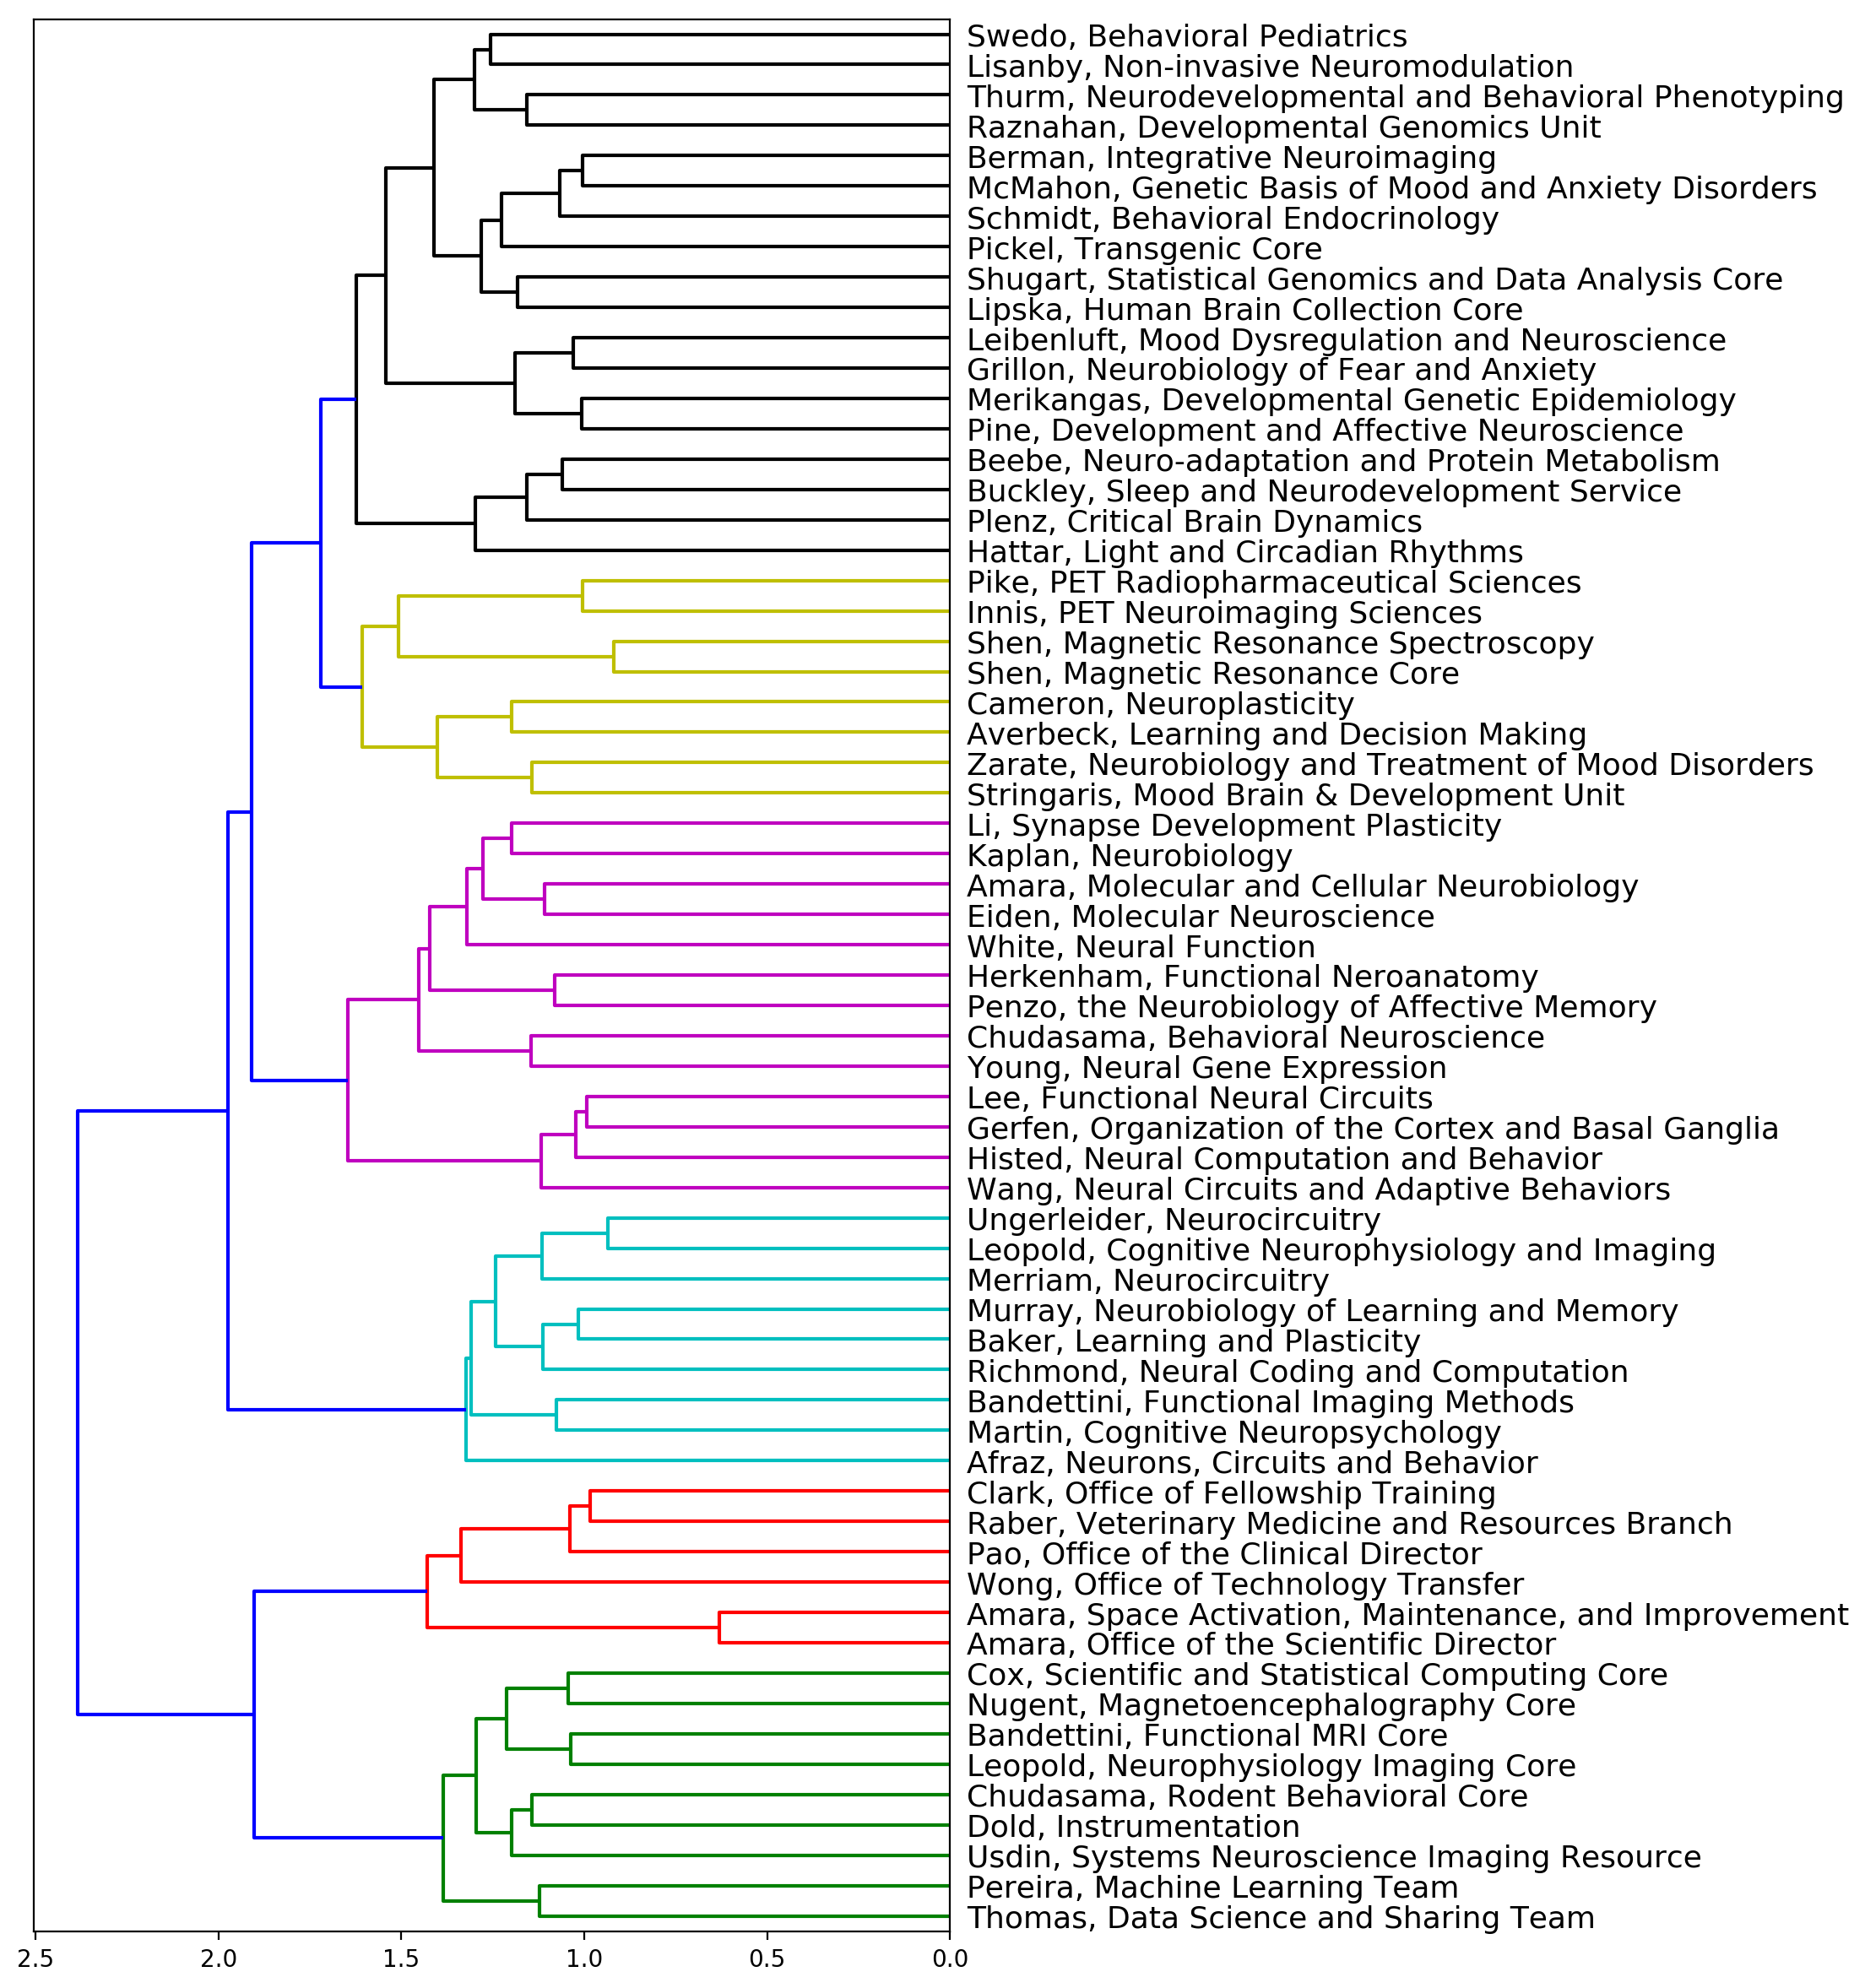

In [46]:
import scipy.cluster.hierarchy as shc

color_helped = False
color_unhelped = False

Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(7, 15), dpi=200)

dend = shc.dendrogram(Z, labels=pi_df['label'].values, orientation='left', color_threshold=1.65, leaf_font_size=13, ax=ax)

ylbls = ax.get_ymajorticklabels()

for lbl in ylbls:
    if color_helped & pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('b')
    if color_unhelped & ~pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('r')


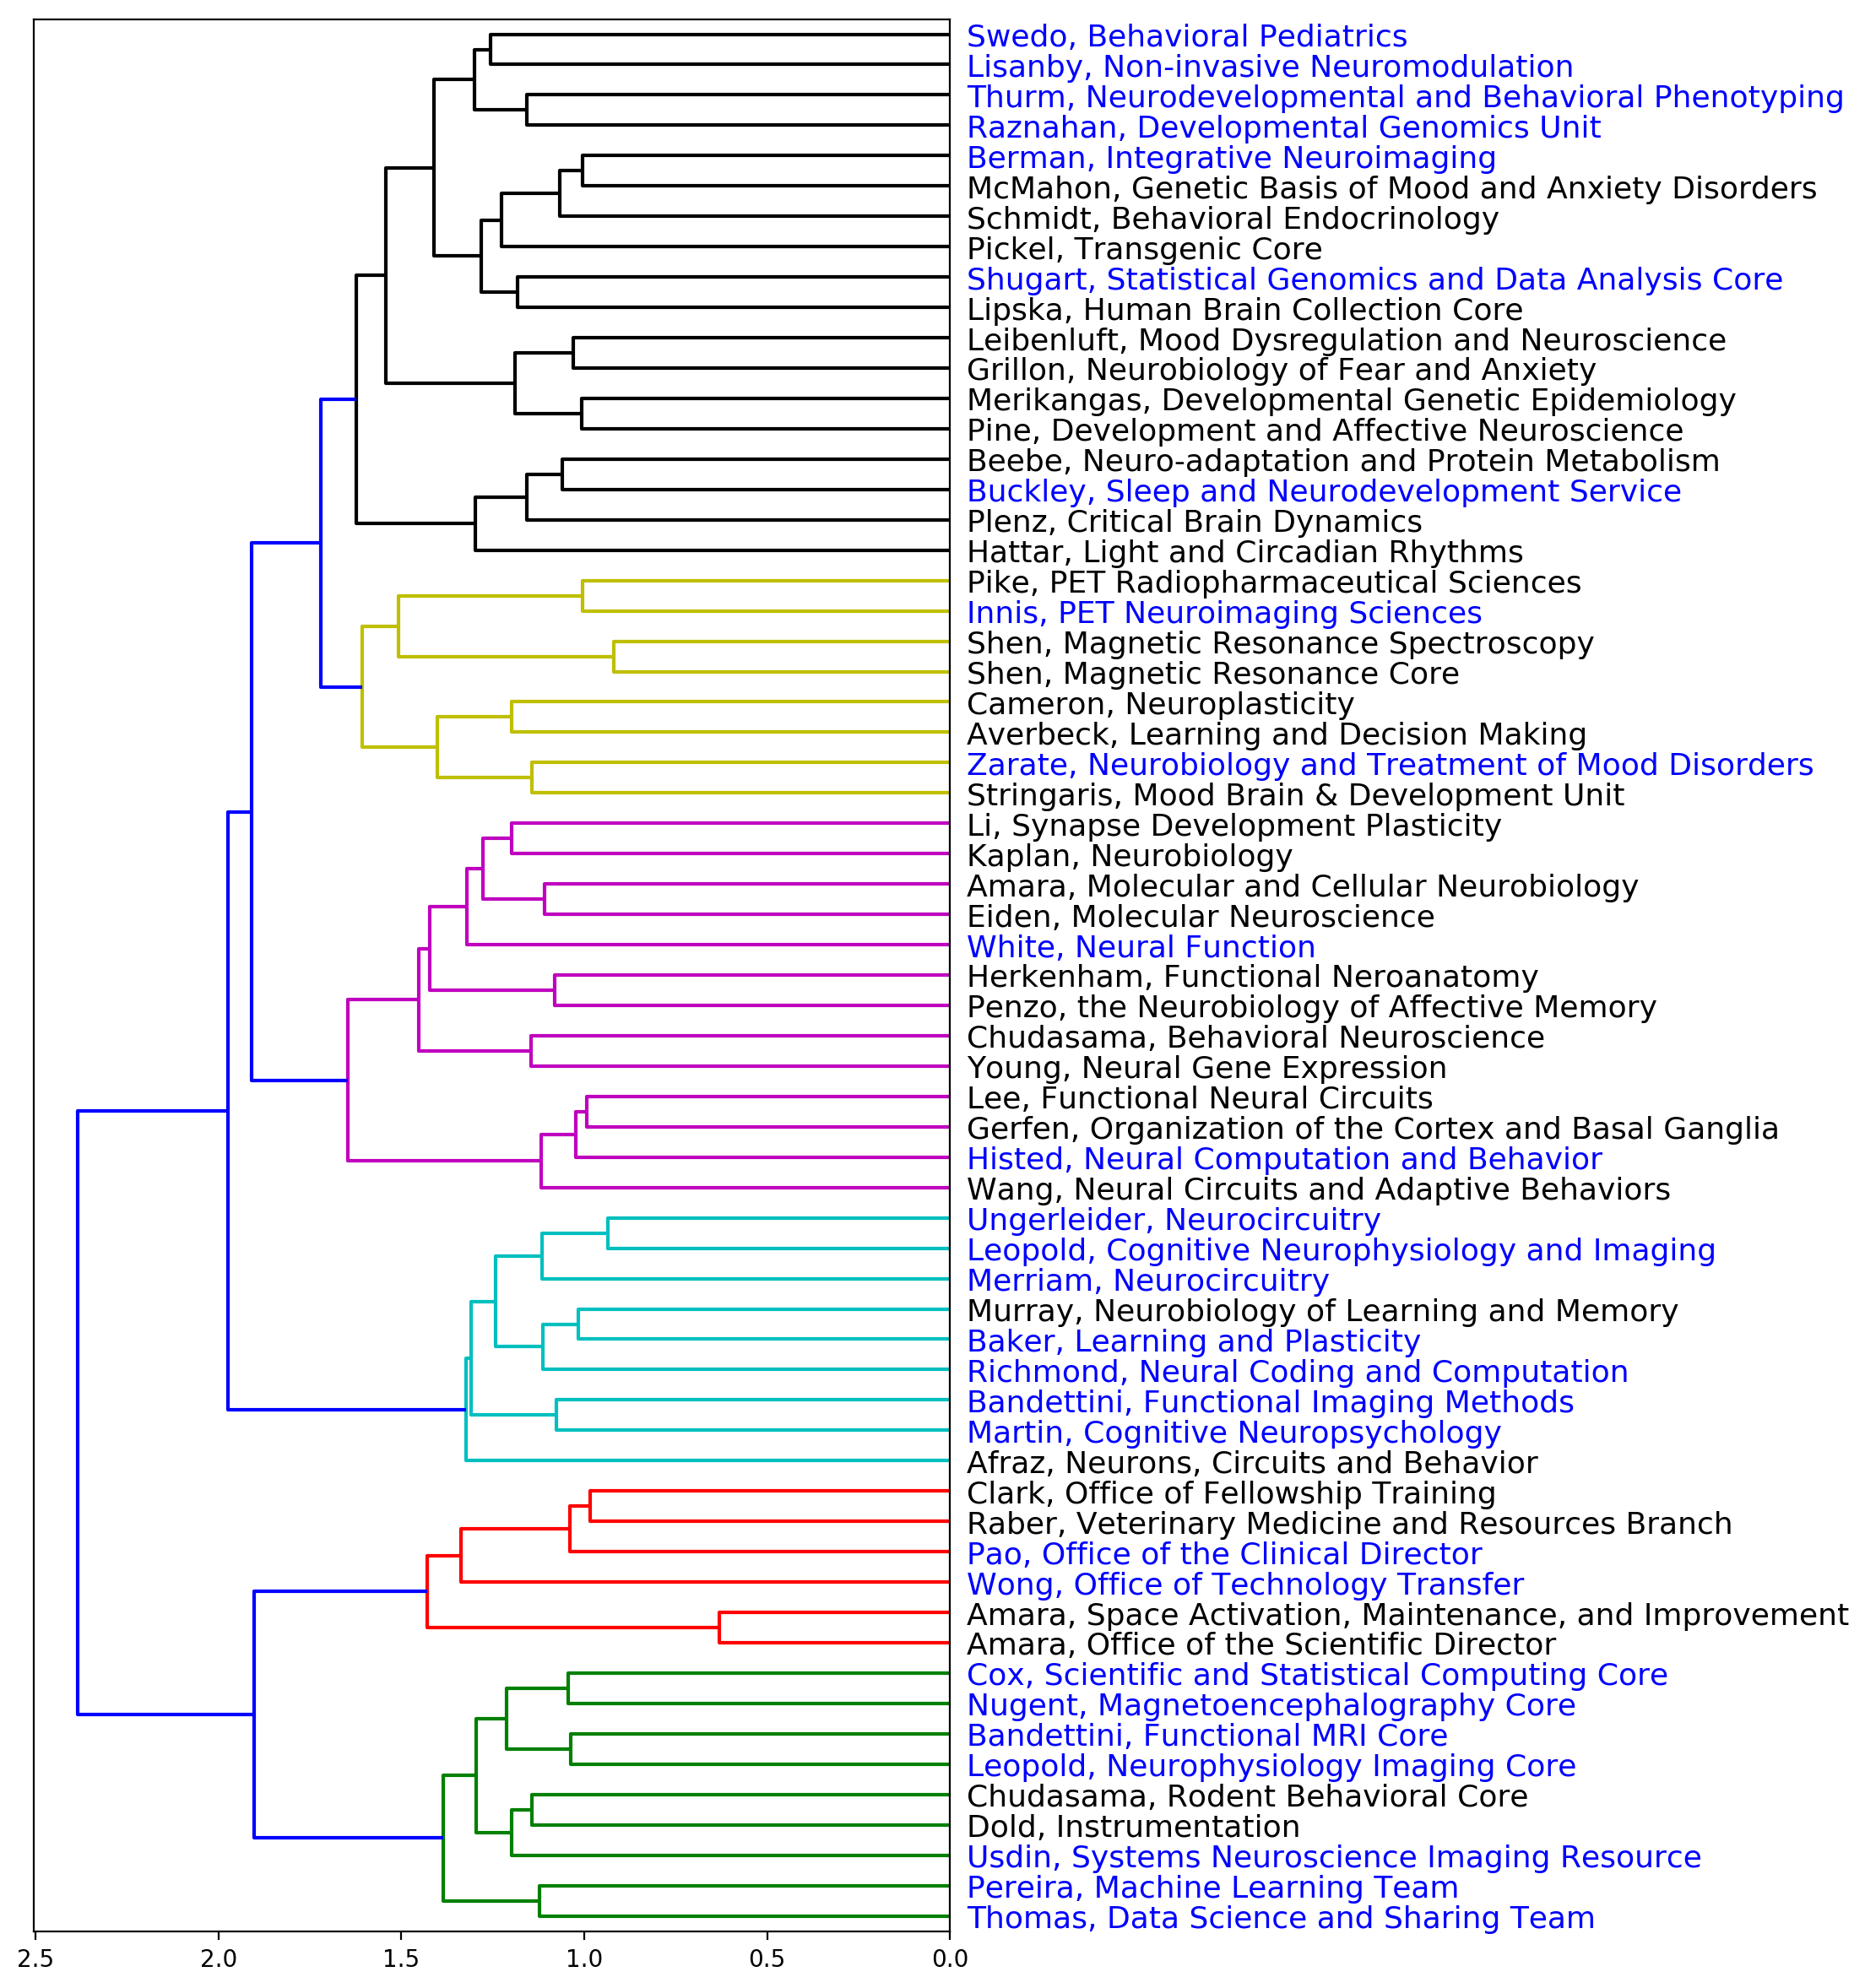

In [47]:
color_helped = True
color_unhelped = False

Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(7, 15), dpi=200)

dend = shc.dendrogram(Z, labels=pi_df['label'].values, orientation='left', color_threshold=1.65, leaf_font_size=13, ax=ax)

ylbls = ax.get_ymajorticklabels()

for lbl in ylbls:
    if color_helped & pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('b')
    if color_unhelped & ~pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('r')

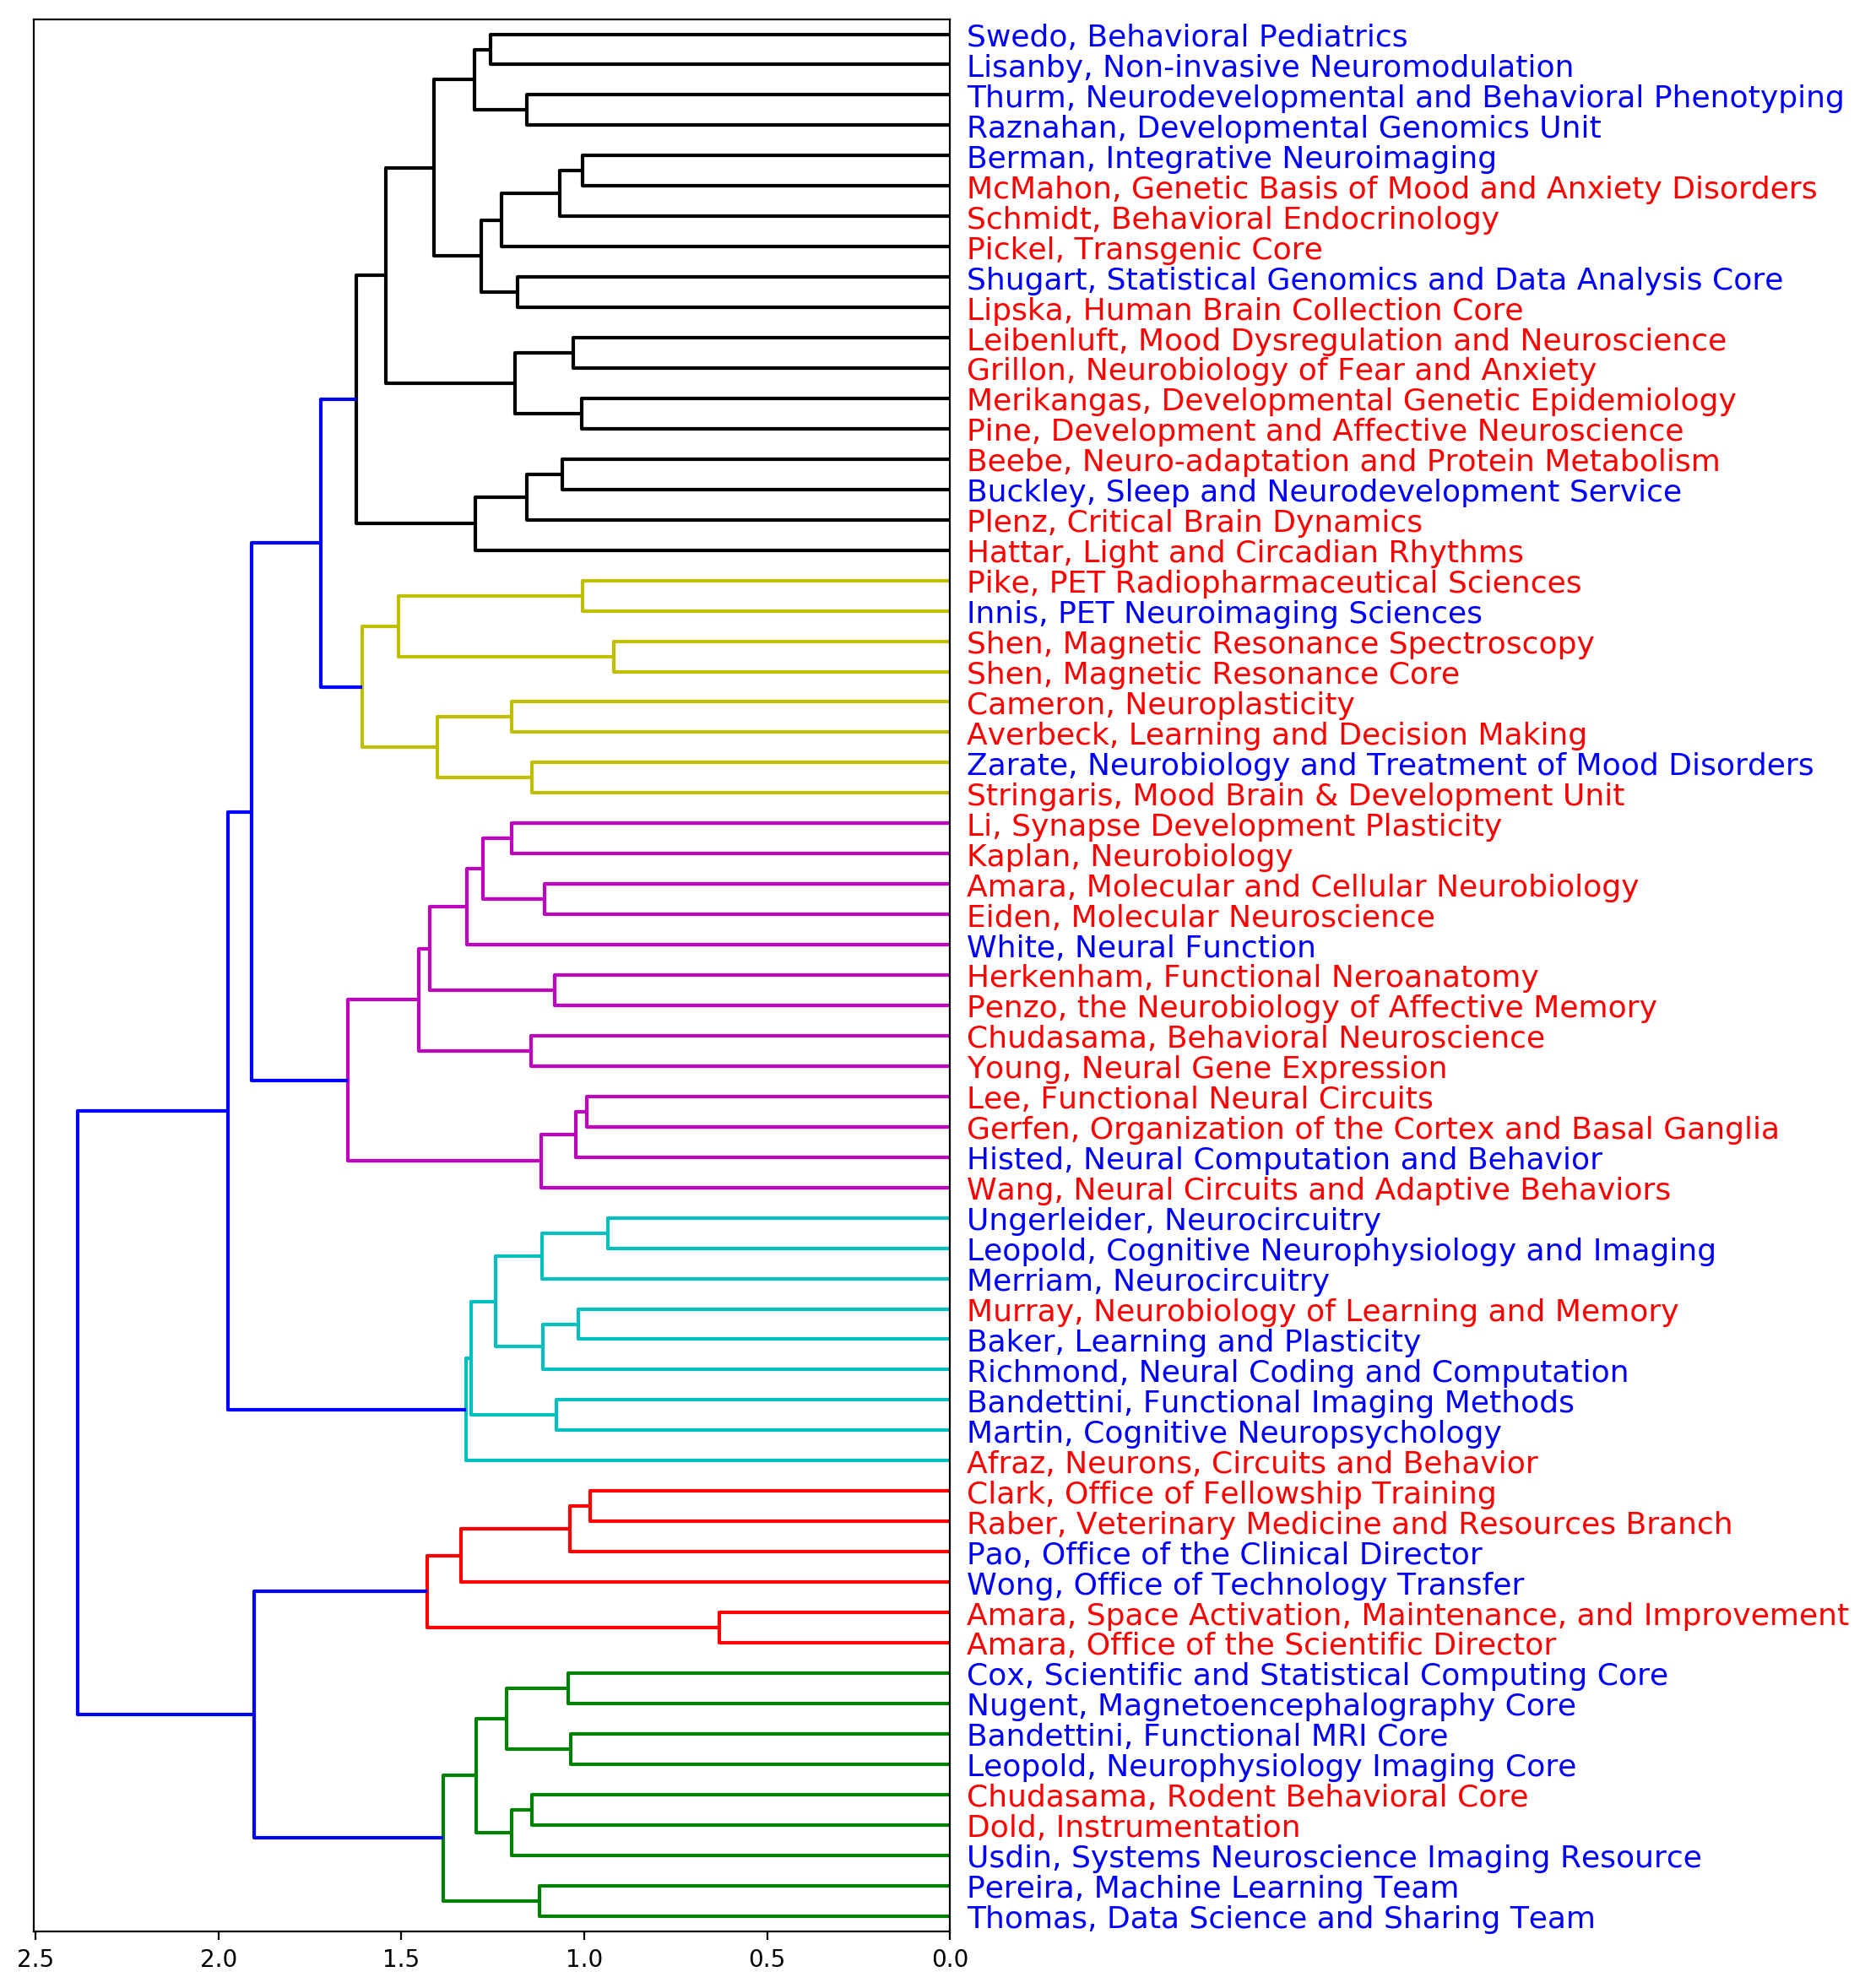

In [48]:
color_helped = True
color_unhelped = True

Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(7, 15), dpi=200)

dend = shc.dendrogram(Z, labels=pi_df['label'].values, orientation='left', color_threshold=1.65, leaf_font_size=13, ax=ax)

ylbls = ax.get_ymajorticklabels()

for lbl in ylbls:
    if color_helped & pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('b')
    if color_unhelped & ~pi_df.loc[pi_df.label == lbl.get_text(), 'helped'].values[0]:
        lbl.set_color('r')

In [49]:
ro_df = pj_df.groupby('Research Organization',as_index=False)[['pj_text']].sum()
ro_df['label'] = ro_df['Research Organization'].str.replace(', NIMH', '')

In [50]:
ro_df

Research Organization  \
0                                  Developmental Genomics Unit, NIMH   
1                                          Functional MRI Core, NIMH   
2                                  Human Brain Collection Core, NIMH   
3            Laboratory of Molecular and Cellular Neurobiology, NIMH   
4                                      Magnetic Resonance Core, NIMH   
5                                  Magnetoencephalography Core, NIMH   
6                                Mood Brain & Development Unit, NIMH   
7                                 Neurophysiology Imaging Core, NIMH   
8                                Office of Fellowship Training, NIMH   
9                                Office of Technology Transfer, NIMH   
10                             Office of the Clinical Director, NIMH   
11                                      Office of the Director, NIMH   
12                                      Rodent Behavioral Core, NIMH   
13                   Scientific and Statistical Computing Core, NIMH   
14                         Section on Behavioral Endocrinology, NIMH   
15                          Section on Behavioral Neuroscience, NIMH   
16                            Section on Behavioral Pediatrics, NIMH   
17            Section on Cognitive Neurophysiology and Imaging, NIMH   
18                        Section on Cognitive Neuropsychology, NIMH   
19                          Section on Critical Brain Dynamics, NIMH   
20           Section on Development and Affective Neuroscience, NIMH   
21               Section on Developmental Genetic Epidemiology, NIMH   
22                       Section on Functional Imaging Methods, NIMH   
23                           Section on Functional Neroanatomy, NIMH   
24                                  Section on Instrumentation, NIMH   
25                         Section on Integrative Neuroimaging, NIMH   
26                     Section on Learning and Decision Making, NIMH   
27                          Section on Learning and Plasticity, NIMH   
28                      Section on Light and Circadian Rhythms, NIMH   
29                  Section on Magnetic Resonance Spectroscopy, NIMH   
30                           Section on Molecular Neuroscience, NIMH   
31              Section on Mood Dysregulation and Neuroscience, NIMH   
32                    Section on Neural Coding and Computation, NIMH   
33                                  Section on Neural Function, NIMH   
34                           Section on Neural Gene Expression, NIMH   
35          Section on Neuro-adaptation and Protein Metabolism, NIMH   
36     Section on Neurobiology and Treatment of Mood Disorders, NIMH   
37                 Section on Neurobiology of Fear and Anxiety, NIMH   
38              Section on Neurobiology of Learning and Memory, NIMH   
39                                     Section on Neurobiology, NIMH   
40                                   Section on Neurocircuitry, NIMH   
41                                  Section on Neuroplasticity, NIMH   
42                        Section on PET Neuroimaging Sciences, NIMH   
43                 Section on PET Radiopharmaceutical Sciences, NIMH   
44                   Section on Synapse Development Plasticity, NIMH   
45  Section on the Genetic Basis of Mood and Anxiety Disorders, NIMH   
46                 Statistical Genomics and Data Analysis Core, NIMH   
47                       Systems Neuroscience Imaging Resource, NIMH   
48                                             Transgenic Core, NIMH   
49                          Unit on Functional Neural Circuits, NIMH   
50              Unit on Neural Circuits and Adaptive Behaviors, NIMH   
51                     Unit on Neural Computation and Behavior, NIMH   
52                      Unit on Neurons, Circuits and Behavior, NIMH   
53                        Unit on Non-invasive Neuromodulation, NIMH   
54                Unit on the Neurobiology of Affective Memory, NIMH   
55             

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(ro_df['pj_text'].values)


/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dr', 'dure', 'e.g', 'i.e', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


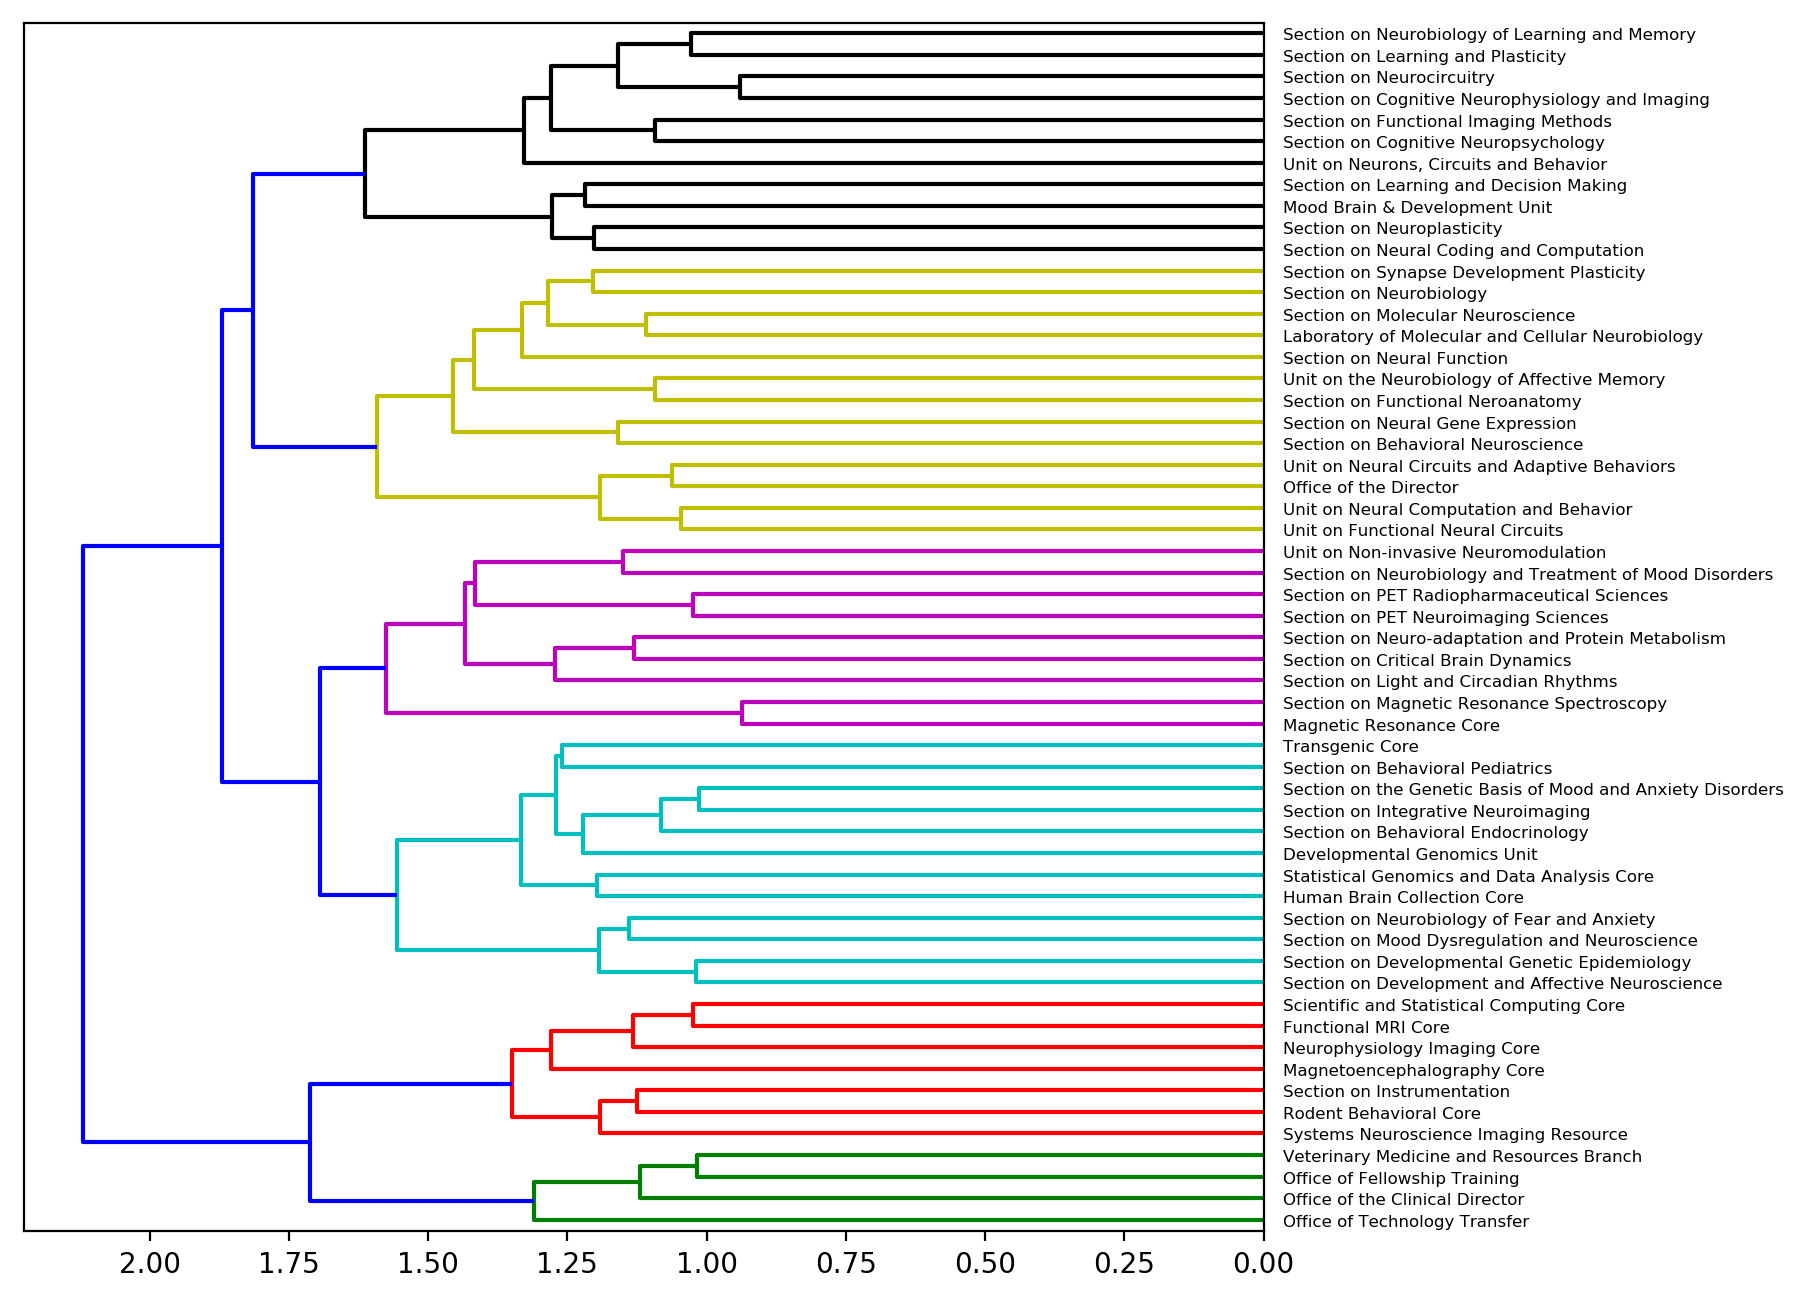

In [52]:
import scipy.cluster.hierarchy as shc
Z = shc.linkage(tfidf_matrix.toarray(), method='ward')
fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
dend = shc.dendrogram(Z, labels=ro_df['label'].values, orientation='left', color_threshold=1.65)


# Make network type figures based on collaborations

In [53]:
pi_collab = []

pi_gb = pj_df.groupby(['PI', 'ro'],as_index=False)[['pj_text']]
for (PI, ro),df in pi_gb:
    NIMH_collab = df.loc[df.NIMH_collab.notnull(), 'NIMH_collab'].values
    if len(NIMH_collab) > 0:
        if len(NIMH_collab) > 1:
            NIMH_collab = np.hstack(NIMH_collab)
        else:
            NIMH_collab = np.array(NIMH_collab[0])
        for dat in NIMH_collab:
            pc = {}
            pc['pi'] = PI
            pc['ro'] = ro
            parts = dat.split('(')
            assert len(parts) == 2
            pc['collab'] = parts[0]
            pc['institute'] = parts[1].strip(')')
            pc['scope'] = 'NIMH'
            pi_collab.append(pc)
    
    EM_collab = df.loc[df.EM_collab.notnull(), 'EM_collab'].values
    if len(EM_collab) > 0:
        if len(EM_collab) > 1:
            EM_collab = np.hstack(EM_collab)
        else:
            EM_collab = np.array(EM_collab[0])
    ii = 0
    while ii != len(EM_collab):
        cur_val = EM_collab[ii]
        next_val = EM_collab[ii+1]
        pc = {}
        pc['pi'] = PI
        pc['ro'] = ro
        parts = dat.split('(')
        assert len(parts) == 2
        pc['collab'] = cur_val
        pc['scope'] = 'Extramural'

        if '(' in next_val:
            pc['institute'] = next_val.strip(')').strip('(')
            ii +=1
        pi_collab.append(pc)
        ii += 1
        
    NIH_collab = df.loc[df.NIH_collab.notnull(), 'NIH_collab'].values
    if len(NIH_collab) > 0:
        if len(NIH_collab) > 1:
            NIH_collab = np.hstack(NIH_collab)
        else:
            NIH_collab = np.array(NIH_collab[0])
        for dat in NIH_collab:
            pc = {}
            pc['pi'] = PI
            pc['ro'] = ro
            parts = dat.split('(')
            assert len(parts) >= 2
            pc['collab'] = parts[0]
            pc['institute'] = parts[-1].replace(')', '')
            pc['scope'] = 'NIH'
            pi_collab.append(pc)

In [54]:
pi_collab = pd.DataFrame(pi_collab)

In [55]:
pj_df['section_only'] = pj_df.ro.str.replace(", NIMH", "")

In [166]:
pj_df[pj_df['PI'].str.contains('Clark')]

2018 Fiscal Year NIH_collab NIMH_collab EM_collab  \
89   October 01, 2017 -  September 30, 2018        NaN         NaN       NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Goals and Objectives  \
89  \nThe NIMH Office of Fellowship Training (OFT), located in the Division of Intramural Research Programs (IRP), Office of the Scientific Director, provides oversight and development of the IRP's integrated multi-disciplinary fellowship training program, and administrative support and resources for all training-related activities. The Office is responsible for fellowship training and personnel-related actions of NIMH Intramural Research Training Award recipients (IRTAs), Visiting Fellows, Rese...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Keywords  \
89  \nResponsible Conduct of Research Training, Fellowship Training, NIMH IRP Fellows' Scientific Training Day, NIMH IRP Orientations, Summer Intern Program, Graduate Partnership Programs, Grantsmanship Workshops, Memorial Fellowship Awards, Diversity and Inclusion Funding, Career and Professional Development Seminars/Workshops, Trainee Travel Award Program, OFT Steering Committee, NIMH IRP Annual Julius Axelrod Symposium, Women Scientist Discussion Series, IRP Investigators' Seminar Series, Sci...   

                                                                   Lab Staff and Collaborators  \
89  \n\n\n\n\n\nAneka Phillipa Reid\n\n\n\nSandy  Gomez\n\n\n\n\n\n\n\nMeera Ashwin Shah\n\n\n   

   Principal Investigator Project Bibliography Publications Generated  \
89                    NaN                  NaN                    NaN   

                     Report Title                Research Organization  \
89  Office of Fellowship Training  Office of Fellowship Training, NIMH   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Summary  \
89  \nIn fiscal year 2018 (FY18) the OFT processed personnel cases for approximately 693 fellows including 190 Special Volunteers. The OFT provided training to all NIMH IRP administrative staff on the processing of trainee personnel cases. The OFT provided 13 faculty with 17 Predoc IRTA slots including travel and tuition, and 15 faculty with 19 diversity and inclusion slots for Postbac IRTAs. The OFT provided monthly orientations which covered information relevant to the NIH and NIMH organizatio...   

         pj_num    ipid  more_references            Lead Investigator  \
89  MH002916-11  106137             True  \nJanet Elizabeth Clark\n\n   

              Supervisor of Record                     PI short_pj_num  \
89  \n\nSusan G Amara; PhD \n \n\n  Janet Elizabeth Clark       002916   

    FY Total Cost by IC  \
89   

In [57]:
collab_inst_cleaning = {'Behavioral Endocrinology Branch': 'Section on Behavioral Endocrinology',
                        'Child Psychiatry Branch': 'Developmental Genomics Unit',
                        'Clinical and Translational Neuroscience Branch': 'Section on Integrative Neuroimaging',
                        'Developmental Neurogenomics Unit': 'Developmental Genomics Unit',
                        'Developmental Trajectories of Mental Disorders Branch': 'DROP',
                        'Division of Intramural Research Programs': 'Transgenic Core',
                        'Emotion and Development Branch': 'Section on Development and Affective Neuroscience',
                        'Experimental Therapeutics and Pathophysiology Branch': 'Section on Neurobiology and Treatment of Mood Disorders',
                        'Genetic Epidemiology Branch': 'Section on Developmental Genetic Epidemiology',
                        'Human Genetics Branch': 'Section on the Genetic Basis of Mood and Anxiety Disorders',
                        'Laboratory of Brain and Cognition': 'Section on Learning and Plasticity',
                        'Laboratory of Cerebral Metabolism': 'Section on Neuro-adaptation and Protein Metabolism',
                        'Laboratory of Genetics': 'Systems Neuroscience Imaging Resource',
                        'Laboratory of Molecular Biology': 'Section on Neurobiology',
                        'Laboratory of Molecular Pathophysiology and Experimental Therapeutics': 'Section on Functional Neroanatomy',
                        'Laboratory of Neuropsychology': 'Section on Learning and Decision Making',
                        'Laboratory of Neurotoxicology': 'Rodent Behavioral Core',
                        'Laboratory of Systems Neuroscience': 'Section on Critical Brain Dynamics',
                        'Molecular Imaging Branch': 'Section on PET Neuroimaging Sciences',
                        'National Institute of Mental Health': 'Functional MRI Core',
                        'Office of Intramural Research Administration': 'Section on Synapse Development Plasticity',
                        'Office of the Director': 'Scientific and Statistical Computing Core',
                        'Pediatric and Developmental Neuropsychiatry Branch': 'Neurodevelopmental and Behavioral Phenotyping',
                        'Psychosis and Cognitive Studies Section': 'Unit on Neural Circuits and Adaptive Behaviors',
                        'Section On Behavioral Neuropharmacology': 'Section on Cognitive Neurophysiology and Imaging',
                        'Section on Analytical Biochemistry': 'DROP',
                        'Section on Childhood Neuropsychiatric Disorders': 'Developmental Genomics Unit',
                        'Section on Cognitive Neuroscience': 'Section on Cognitive Neurophysiology and Imaging',
                        'Section on Developmental Brain Imaging': 'DROP',
                        'Section on Directed Gene Transfer': 'DROP',
                        'Section on Functional Brain Imaging': 'Section on Learning and Plasticity',
                        'Section on Fundamental Neuroscience': 'Systems Neuroscience Imaging Resource',
                        'Section on Light and Biological Rhythms': 'Section on Light and Circadian Rhythms',
                        'Section on Molecular Neuropsychiatry': 'Section on PET Neuroimaging Sciences',
                        'Section on Neuroanatomy': 'Section on Functional Neroanatomy',
                        'Section on Neurophysiology': 'Section on Neurobiology of Learning and Memory',
                        'Section on Synapse Development and Plasticity': 'Section on Synapse Development Plasticity',
                        'Unit on Genetics of Mood and Anxiety Disorders': 'Section on the Genetic Basis of Mood and Anxiety Disorders',
                        'Unit on Neuroplasticity': 'Section on Neuroplasticity'}
pi_collab['institute'] = pi_collab.institute.apply(lambda x: collab_inst_cleaning[x] if x in collab_inst_cleaning else x)

In [58]:
# Drop some collaborator rows
pi_collab = pi_collab.loc[pi_collab.institute !='DROP', :]
# make sure everyone can match
assert (~pi_collab.query('scope == "NIMH"').institute.isin(pj_df.section_only.unique())).sum() == 0

In [59]:
pi_collab['collabing_pi'] = pi_collab.loc[pi_collab.scope == 'NIMH', 'institute'].apply(lambda x: pj_df.loc[pj_df.section_only == x, 'PI'].values[0])

In [63]:
# Make edge list
el = pi_collab.loc[pi_collab.scope=='NIMH', ['pi', 'collabing_pi']].drop_duplicates().to_records(index=False)

img_dir = data_path / 'PI_pics'
imgs = list(img_dir.glob('*'))

pic_lut = {}

for img in imgs:
    pic_name = img.parts[-1].split('_')[0].strip('.jpg').split('-')[0]
    name_ind = np.array([(pic_name) in piname for piname in pj_df.PI.str.lower().unique()])
    if name_ind.sum() > 1:
        name_ind = np.array([(pic_name + ';') in piname for piname in pj_df.PI.str.lower().unique()])
    if name_ind.sum() == 1:
        pi_name = pj_df.PI.unique()[name_ind][0]
        pic_lut[pi_name] = img.absolute().resolve().as_posix()

In [64]:
G = nx.Graph()
G.add_edges_from(el)

G.add_node('Susan G Amara; PhD')

In [65]:
# Within NIMH Stats
total_collabs = pi_collab.query('scope == "NIMH"').collab.notnull().sum()
n_with_collabs = len(G.nodes) 
n_pi = len(pj_df.PI.unique())
pi_no_collab = pj_df.PI[~pj_df.PI.isin(list(G.nodes))].unique()
print(f"Total number of collabs: {total_collabs}")
print(f"Number of PIs with NIMH collabborations: {n_with_collabs}")
print(f"PIs with no NIMH collabborations listed: {pi_no_collab}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_collabs}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 326
Number of PIs with NIMH collabborations: 55
PIs with no NIMH collabborations listed: ['Janet Elizabeth Clark' 'Jennifer S Wong']
Mean number of collabs per PI with collabs: 5.927272727272728
Mean number of collabs per all PIs: 5.719298245614035
Mean number of collabs per all PIs but not tech transfer or training: 5.927272727272728


In [67]:
# External Stats
n_with_EM = (pj_df.groupby('PI').EM_collab.count() > 0).sum()
n_no_EM = (pj_df.groupby('PI').EM_collab.count() == 0).sum()
total_collabs = pi_collab.query('scope == "Extramural"').shape[0]
total_institutes = pi_collab.query('scope == "Extramural"').institute.nunique()

print(f"Total number of collabs: {total_collabs}")
print(f"Unique Institutes: {total_institutes}")
print(f"Number of investigators with extramural collaborators: {n_with_EM}")
print(f"Number of investigators without extramural collaborators: {n_with_EM}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_EM}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not tech transfer or training: {total_collabs/(n_pi - 2)}")

Total number of collabs: 470
Unique Institutes: 331
Number of investigators with extramural collaborators: 46
Number of investigators without extramural collaborators: 46
Mean number of collabs per PI with collabs: 10.217391304347826
Mean number of collabs per all PIs: 8.24561403508772
Mean number of collabs per all PIs but not tech transfer or training: 8.545454545454545


In [69]:
degree_df = pd.DataFrame([{'pi':nn, 'degree':G.degree[nn]} for nn in G.nodes])
degree_df['weight'] = 1/(degree_df.degree**2)

In [70]:
degree_df.sort_values('degree')

degree                              pi    weight
54       0              Susan G Amara; PhD       inf
52       1              Mark H Histed; PhD  1.000000
23       1       Susan Elizabeth Swedo; MD  1.000000
44       1           Benjamin H White; PhD  1.000000
28       2       Barry Bernard Kaplan; PhD  0.250000
41       2              Francisco  Pereira  0.250000
42       2           Arash  Afraz; MD, PhD  0.250000
40       2             Elisha Prem Merriam  0.250000
21       2                 Ashura  Buckley  0.250000
8        3               Alex  Martin; PhD  0.111111
22       3            Carolyn E Beebe; PhD  0.111111
35       3           Charles R Gerfen; PhD  0.111111
34       3            Yin Yao Shugart; PhD  0.111111
53       3             Peter J Schmidt; MD  0.111111
51       3           Miles  Herkenham; PhD  0.111111
46       4           Mario Alexander Penzo  0.062500
32       4              Victor W Pike; PhD  0.062500
50       4              Samer Saleh Hattar  0.062500
25       4      Francis Joseph McMahon; MD  0.062500
24       4           Barbara K Lipska; PhD  0.062500
43       4          Heather A Cameron; PhD  0.062500
27       4                  Zheng  Li; PhD  0.062500
38       5       Leslie G Ungerleider; PhD  0.040000
45       5                  Jun  Shen; PhD  0.040000
37       5     Walter Scott Young; MD, PhD  0.040000
18       6      Kathleen R Merikangas; PhD  0.027778
47       6             Dietmar  Plenz; PhD  0.027778
16       6            Argyrios  Stringaris  0.027778
14       6     Sarah Hollingsworth Lisanby  0.027778
30       6            Barry J Richmond; MD  0.027778
7        7             Audrey E Thurm; PhD  0.020408
36       7                Lee E Eiden; PhD  0.020408
0        7              Adam G Thomas; PhD  0.020408
17       7           Ellen  Leibenluft; MD  0.020408
33       8     Elisabeth Adams Murray; PhD  0.015625
48       8       Theodore B Usdin; MD, PhD  0.015625
5        8                 Armin  Raznahan  0.015625
15       8                Daniel  Pine; MD  0.015625
19       8               Soohyun  Lee; PhD  0.015625
20       8             Kuan Hong Wang; PhD  0.015625
13       9         Christian  Grillon; PhD  0.012346
2        9               Maryland  Pao; MD  0.012346
26      10               Robert  Innis; MD  0.010000
3       11       Allison Carol Nugent; PhD  0.008264
31      12                Bruno B Averbeck  0.006944
39      13          Yogita  Chudasama; PhD  0.005917
11      13              Karen F Berman; MD  0.005917
9       14      Christopher Ian Baker; PhD  0.005102
29      14         James M Pickel; AB, PhD  0.005102
1       15            David A Leopold; PhD  0.004444
6       15       Carlos Alberto Zarate; MD  0.004444
4       16                Robert  Cox; PhD  0.003906
10      21     Peter A Bandettini; BS, PhD  0.002268
49      23          James  Raber; DVM, PhD  0.001890
12      25  George Raphael Dold; MME, BSEE  0.001600

In [71]:
shells = [degree_df.loc[degree_df.degree >= 10, 'pi'].values,
degree_df.loc[degree_df.degree < 10, 'pi'].values]

In [72]:
for nn in G.nodes:
    G.nodes[nn]['img'] = pic_lut[nn]


In [73]:
for n1,n2 in G.edges:
    
    G.edges[(n1,n2)]['weight'] = np.max([degree_df.loc[degree_df.pi == n1, 'weight'].values[0],
                                        degree_df.loc[degree_df.pi == n2, 'weight'].values[0]])

In [74]:
sns.set_context('paper', font_scale=0.1)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


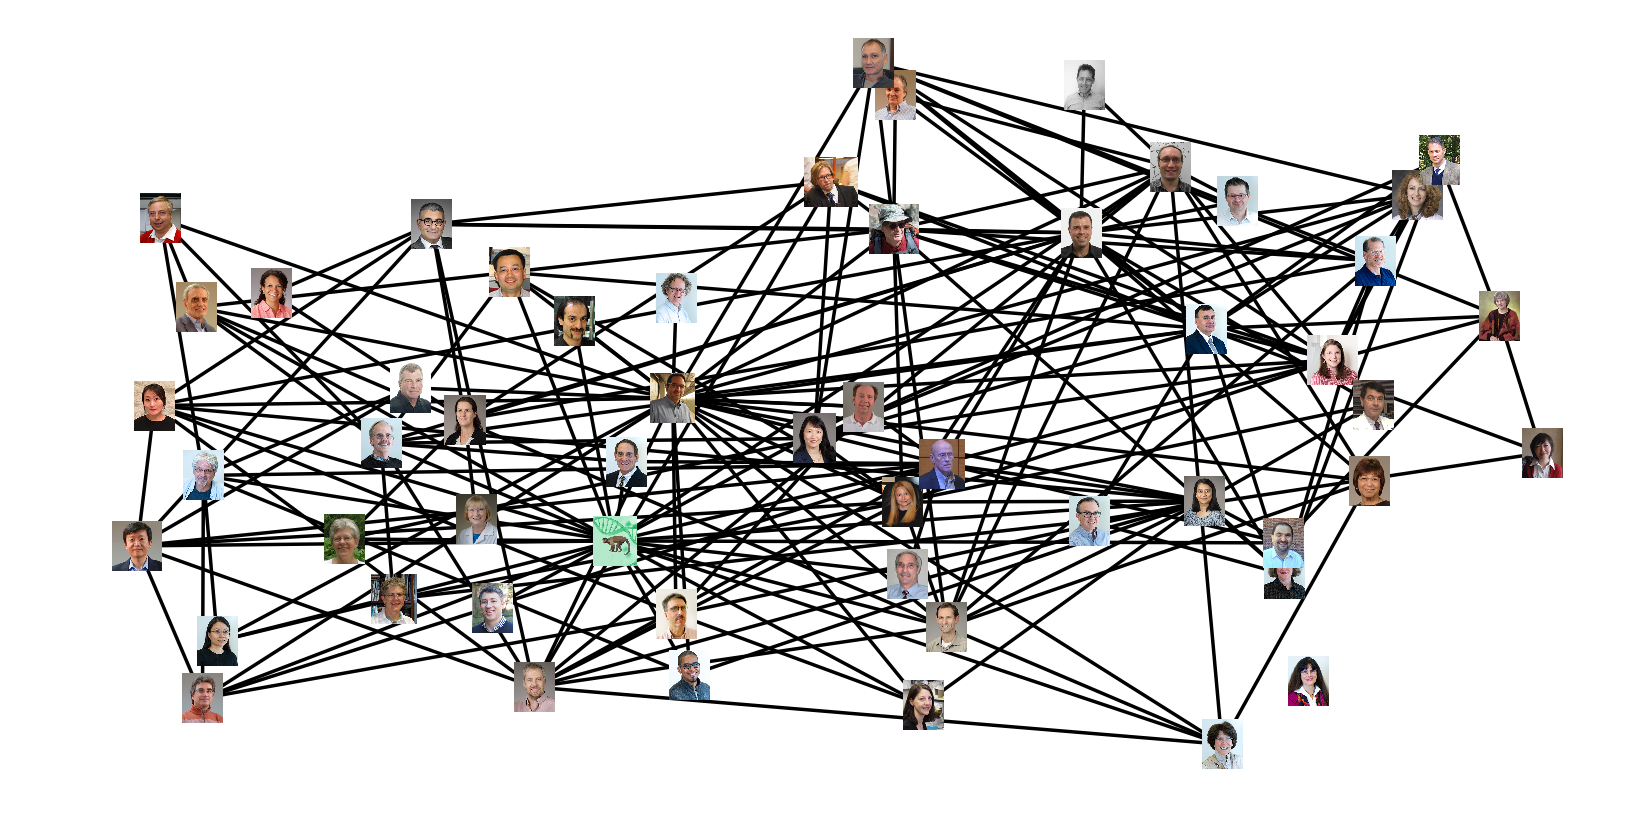

In [632]:
# Based on code from: https://gist.github.com/shobhit/3236373

pos = nx.spring_layout(G, k=1/3, seed=4000)

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=100, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations.png', transparent=True)

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


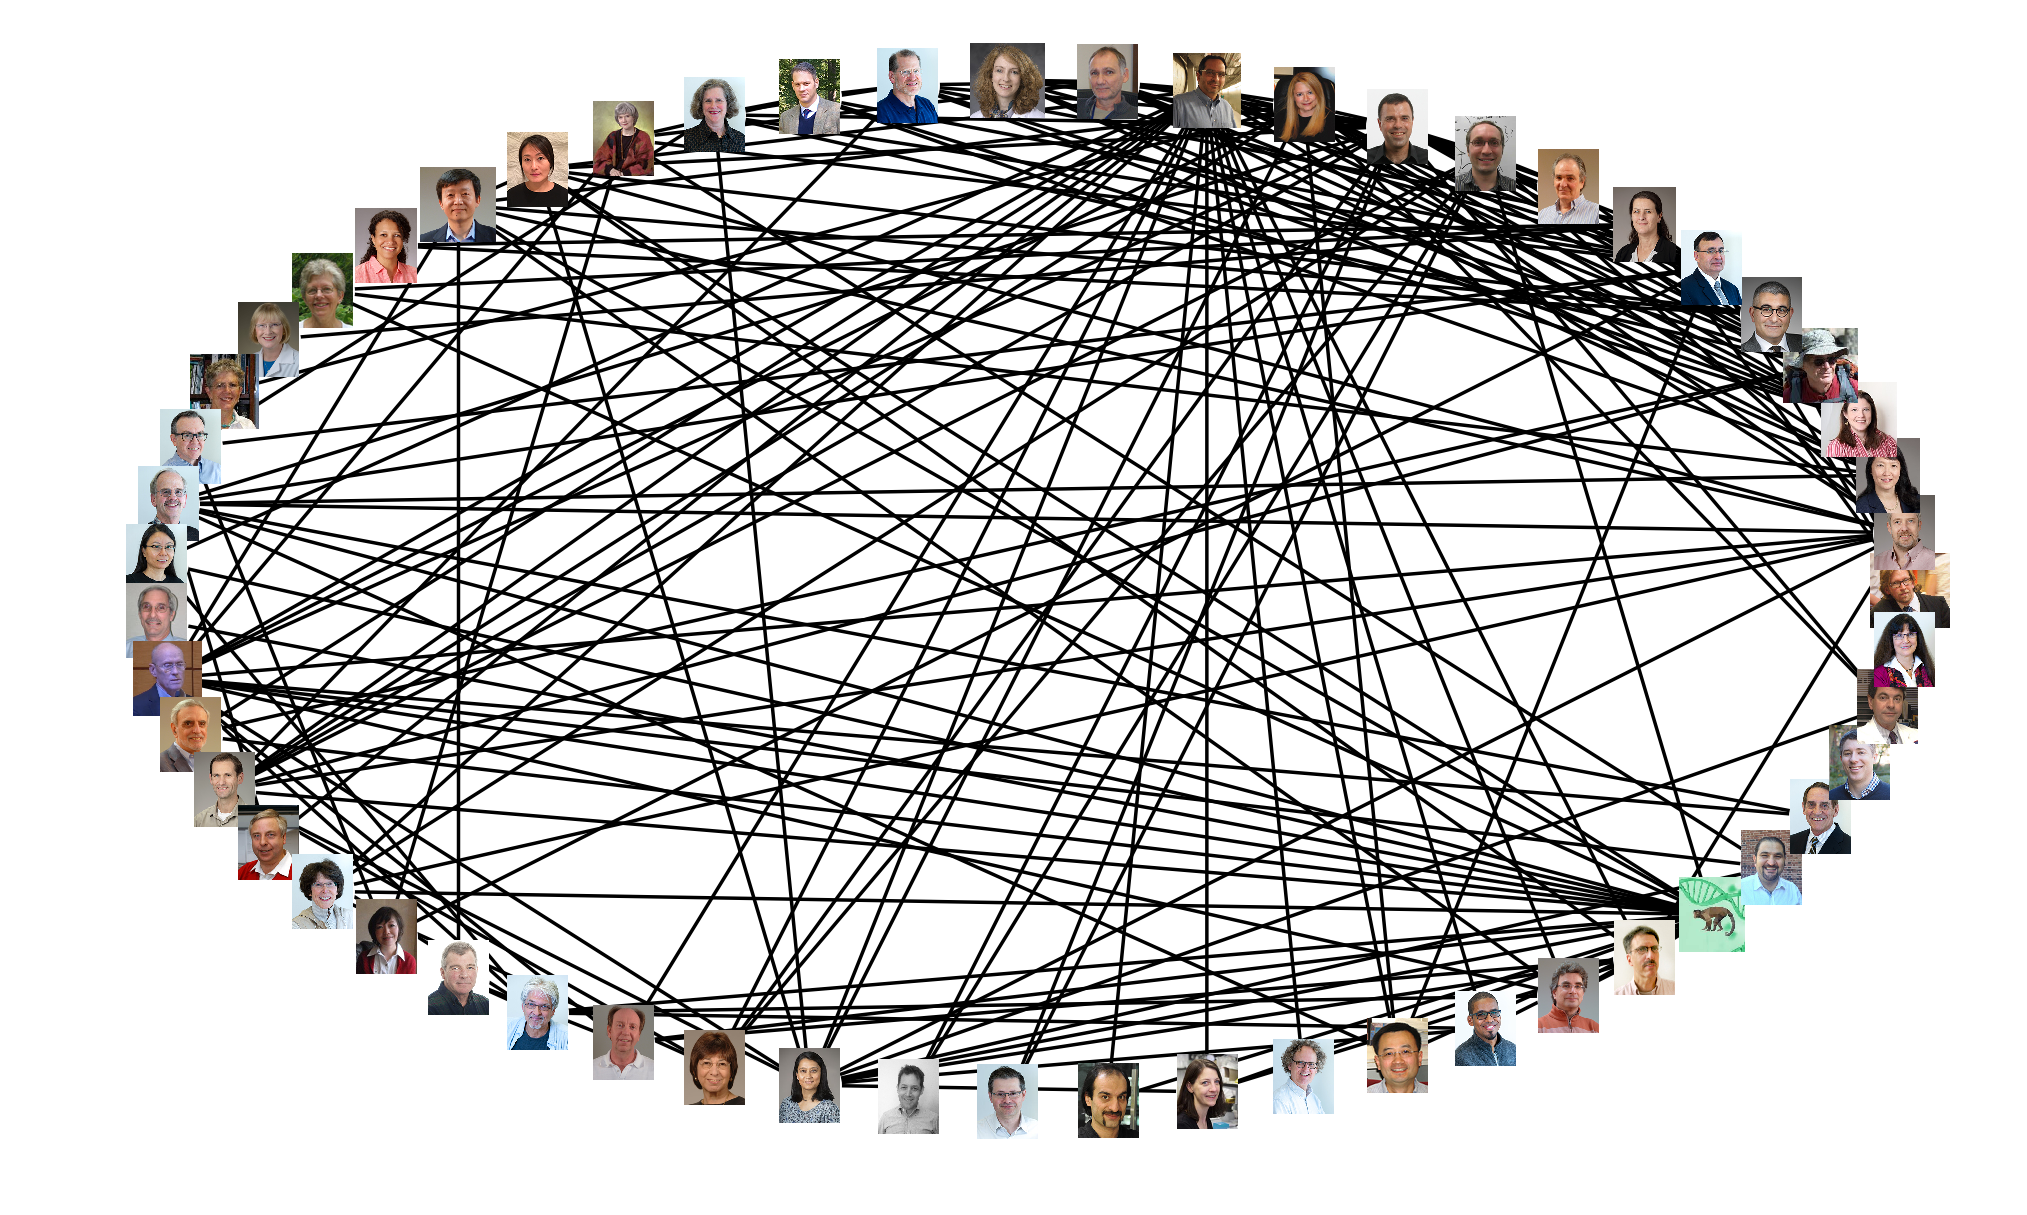

In [633]:
pos = nx.circular_layout(G)
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=250)
nx.draw_networkx(G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=300, node_color='white')
#ax.set_xlim((-1, 1))
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05 # this is the image size
for nn in G.nodes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
    ax.axis('off')
fig.savefig('irp_collaborations_circle.png', transparent=True)

## Make graph for external collaborators

In [90]:
pi_collab.query('scope == "NIH"').institute.unique()

array(['NINDS ', 'NHGRI ', 'NIDDK ', 'NICHD ', 'NIDCR ', 'NCI ', 'NIDCR',
       'NINR', 'NINDS', 'NCI', 'NICHD', 'NHGRI', 'NHLBI', 'NIA', 'NIAAA',
       'CC', 'NIDA', 'NEI ', 'NIBIB', 'CIT ', 'NIBIB ', 'NIAAA ', 'NIA ',
       'CC ', 'OD ', 'NIDDK', 'NCATS', 'NCCIH', 'CIT', 'NINR ', 'NIDA ',
       'NCCIH ', 'NIAID', 'NIDCD', 'NIAID ', 'NIDCD ', 'NHLBI '],
      dtype=object)

In [91]:
pi_collab['institute'] = pi_collab['institute'].str.strip()

In [ ]:
pi_collab.sample()

In [150]:
x_el = pi_collab.loc[pi_collab.scope=='NIH', ['pi', 'institute']].drop_duplicates().sample(frac=1).to_records(index=False)
x_G = nx.Graph()
x_G.add_edges_from(x_el)

In [151]:
pis = pi_collab.loc[pi_collab.scope=='NIH', 'pi'].unique()
institutes = pi_collab.loc[pi_collab.scope=='NIH', 'institute'].unique()
shells = [institutes,
          pis]

In [152]:
for nn in x_G.nodes:
    try:
        x_G.nodes[nn]['img'] = pic_lut[nn]
    except KeyError:
        pass

In [153]:
palette = sns.color_palette(palette='dark', n_colors=len(institutes))
palette = sns.hls_palette(len(institutes), l=.3, s=.8)
inst_color_lut = {inst:color for inst,color in zip(institutes, palette)}

In [154]:
# Make node color list
node_colors = []
for nn in x_G.nodes:
    if nn in institutes:
        node_colors.append(inst_color_lut[nn]) 
    else:
        node_colors.append((1,1,1))
        
# Make edge color list
edge_colors = []
for n1,n2 in x_G.edges:
    if n1 in institutes:
        edge_colors.append(inst_color_lut[n1])
    else:
        edge_colors.append(inst_color_lut[n2])

In [168]:
# External Stats
n_with_NIH = (pj_df.groupby('PI').NIH_collab.count() > 0).sum()
n_no_NIH = (pj_df.groupby('PI').NIH_collab.count() == 0).sum()
total_collabs = pi_collab.query('scope == "NIH"').shape[0]
total_institutes = pi_collab.query('scope == "NIH"').institute.nunique()

print(f"Total number of collabs: {total_collabs}")
print(f"Unique Institutes: {total_institutes}")
print(f"Number of investigators with non-NIMH IRP collaborators: {n_with_NIH}")
print(f"Number of investigators without non-NIMH IRP collaborators: {n_no_NIH}")

print(f"Mean number of collabs per PI with collabs: {total_collabs/n_with_NIH}")
print(f"Mean number of collabs per all PIs: {total_collabs/n_pi}")
print(f"Mean number of collabs per all PIs but not training: {total_collabs/(n_pi - 1)}")

Total number of collabs: 303
Unique Institutes: 20
Number of investigators with non-NIMH IRP collaborators: 46
Number of investigators without non-NIMH IRP collaborators: 11
Mean number of collabs per PI with collabs: 6.586956521739131
Mean number of collabs per all PIs: 5.315789473684211
Mean number of collabs per all PIs but not training: 5.410714285714286


In [158]:
(pj_df.groupby('PI').NIH_collab.count())[(pj_df.groupby('PI').NIH_collab.count() == 0)]

PI
Arash  Afraz; MD, PhD        0
Argyrios  Stringaris         0
Bruno B Averbeck             0
Christian  Grillon; PhD      0
Daniel  Pine; MD             0
Elisha Prem Merriam          0
Janet Elizabeth Clark        0
Kuan Hong Wang; PhD          0
Leslie G Ungerleider; PhD    0
Mark H Histed; PhD           0
Yin Yao Shugart; PhD         0
Name: NIH_collab, dtype: int64

/Users/nielsond/miniconda3/envs/irp_clust/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


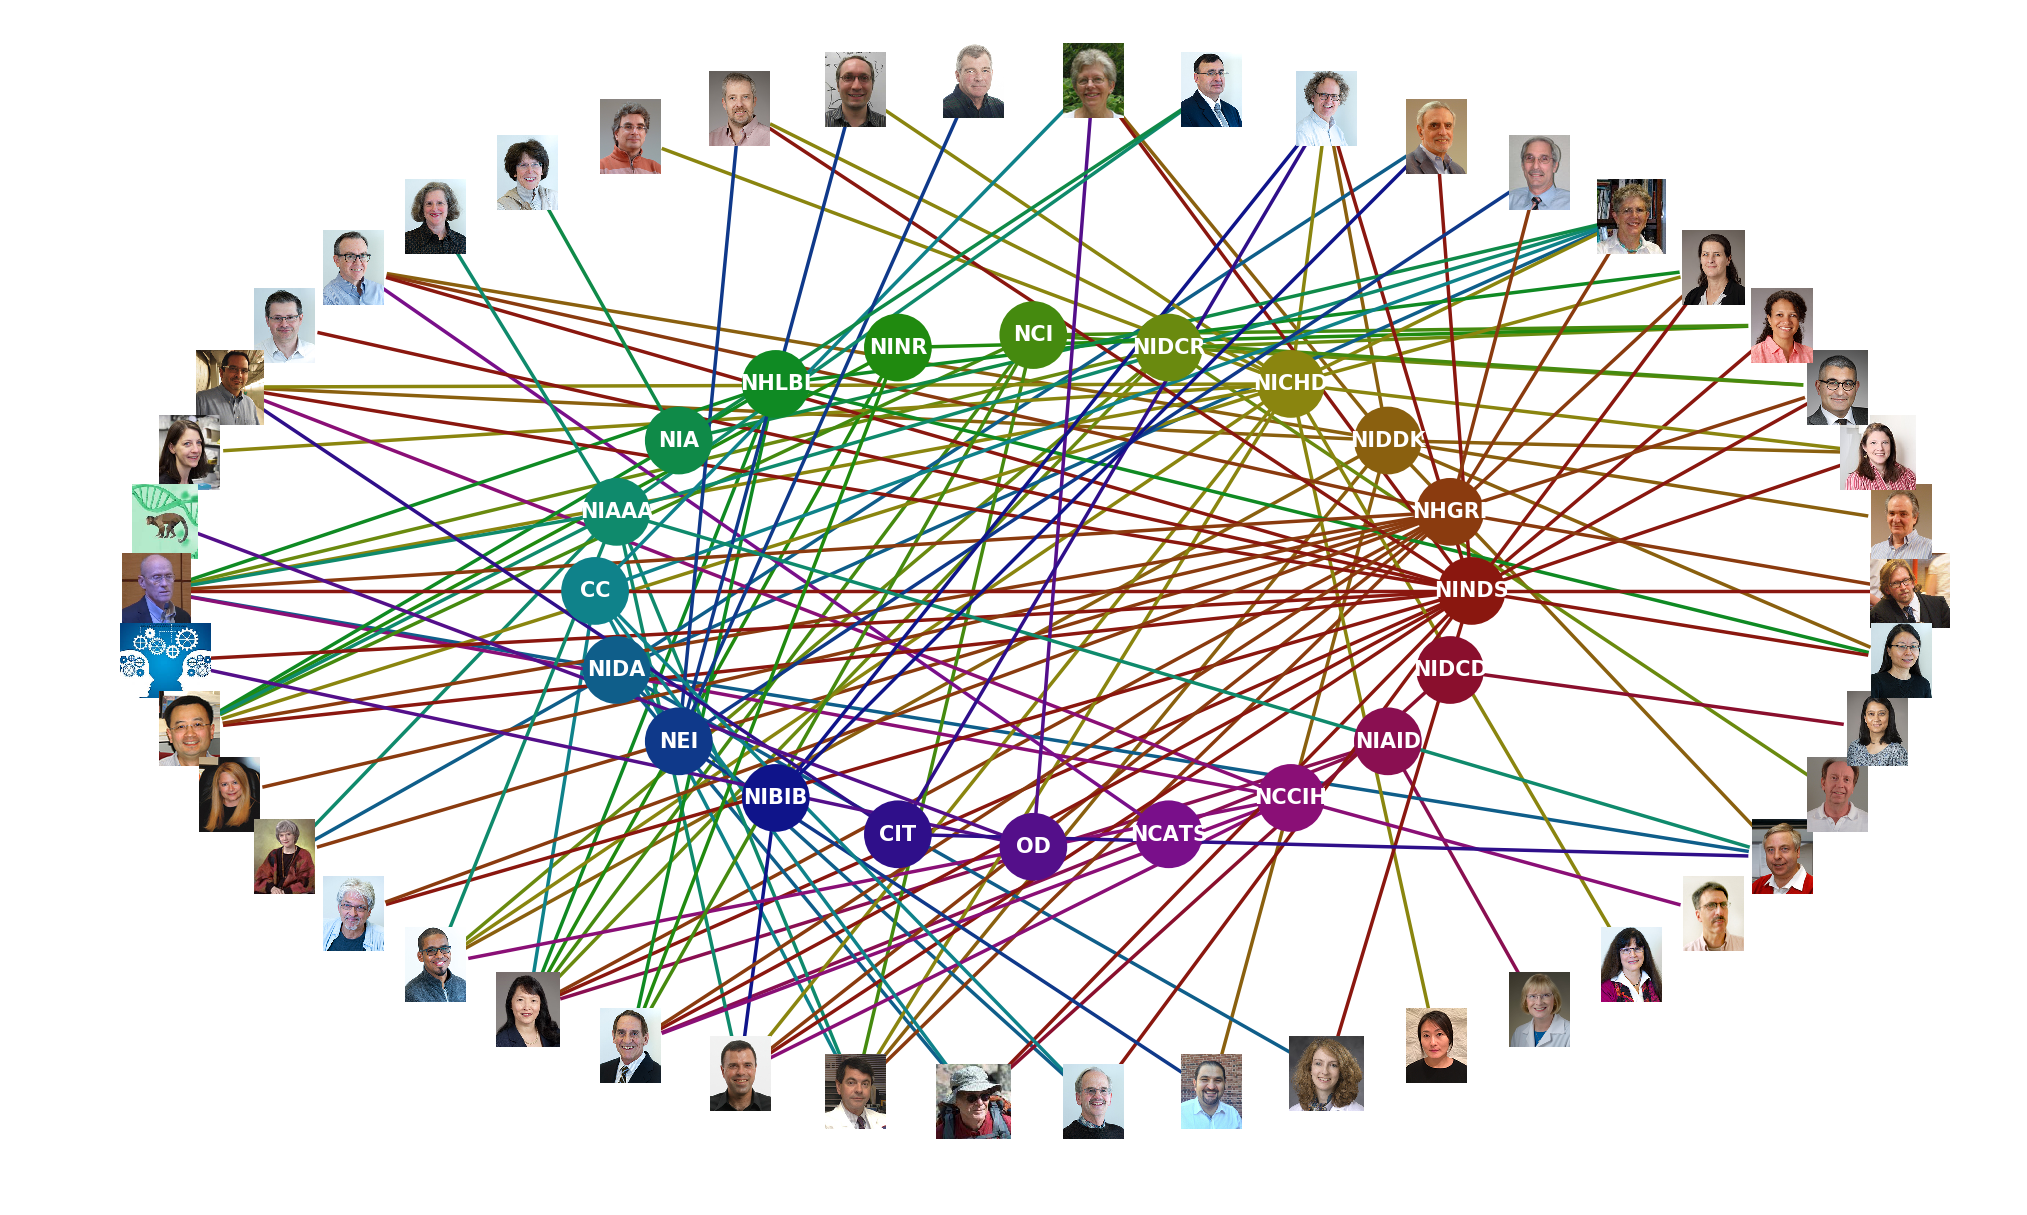

In [165]:
pos = nx.shell_layout(x_G, nlist=shells)
fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=250)
nx.draw_networkx(x_G, ax=ax, font_size=5, pos=pos, with_labels=False, node_size=350, node_color=node_colors, edge_color=edge_colors)
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.05
for nn in pis:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    img_path = x_G.nodes[nn]['img']
    img = Image.open(img_path)
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.axis('off')
ax.axis('off')
for nn in institutes:
    (x,y) = pos[nn]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    ax.text(x, y, nn, color='white', size=6, ha='center', va='center', weight='bold')
    
fig.savefig('nih_collaborations_circle.png', transparent=True)